In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)


def nearest_nonzero_idx(a,x,y):
    r,c = np.nonzero(a)
    min_idx = ((r - x)**2 + (c - y)**2).argmin()
    return r[min_idx], c[min_idx]


def maskedarray_gt(data, value):
    """ Greater than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data > value] = value
    return data


def maskedarray_lt(data, value):
    """ Less than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data < value] = value
    return data


def ts_fromdebris_func(h, a, b, c):
        """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
        Hill Equation"""
        return a * h**c / (b**c + h**c)
def debris_fromts_func(ts, a, b, c):
    """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
    Hill Equation"""
    return (ts * b**c / (a - ts))**(1/c)

# def meltfactor_fromdebris_func(h, a, k, melt_2cm):
#     """ estimate melt factor from debris thickness (h is debris thickness, a and k are coefficients) 
#     Hill equation """
#     melt_h = a / (1 + 2 * k * a * h)
#     melt_factor = melt_h / melt_2cm
#     melt_factor[melt_factor > 1] = 1
#     return melt_factor

def debris_fromts_maskedarray(ts_raw, a, b, c):
    """ Apply debris_fromts_func to masked array
        includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
    Parameters
    ----------
    ts_raw : np.ma.array
        masked array of the unmodified surface temperature
    Returns
    -------
    hd : np.ma.array 
        masked array of the debris thickness (m)
    """
    ts = ts_raw.copy()
    max_value = ts_fromdebris_func(50, a, b, c)
    debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
    debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
    hd = debris_fromts_func(ts.data, a, b, c)
    return hd


def emergence_pixels(gf, vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False, debug=True):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Glacier mask
    glac_mask = np.zeros(vel_x_raw.shape) + 1
    glac_mask[gf.z1.mask] = 0
    
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
        icethickness = icethickness * glac_mask
#     print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
         
    # Redistribute off-glacier volume back onto the nearest pixel on the glacier
    offglac_row, offglac_col = np.where((glac_mask == 0) & (volume_final > 0))
    for nidx in range(0,len(offglac_row)):
        nrow = offglac_row[nidx]
        ncol = offglac_col[nidx]
        ridx, cidx = nearest_nonzero_idx(glac_mask, nrow, ncol)
        # Add off-glacier volume back onto nearest pixel on glacier
        volume_final[ridx,cidx] += volume_final[nrow,ncol]
        volume_final[nrow,ncol] = 0
            
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    if debug:
        print('Mass is conserved?', np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() < 0.01)
        print(np.round(np.absolute(volume_final.sum() - volume_initial.sum()),1), 
              np.round(np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() * 100,2), '%')
        
    if np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() > 0.01:
        print('MASS NOT CONSERVED FOR EMERGENCE VELOCITY')
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity



class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.emvel = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan
        
        self.col_array = None
        self.row_array = None

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()
        

#RGI uses 50 m bins
def hist_plot(gf, bin_width=50.0, dz_clim=(-2.0, 2.0), exportcsv=True, csv_ending='', mb_df=None, outdir_csv=None,
              dc_switch=1):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this
    if mb_df is not None:
        # Align bins with mass balance data
        bin_center_min = mb_df.loc[0,'bin_center_elev_m']
        while bin_center_min > gf.z1.min() + bin_width/2:
            bin_center_min -= mb_bin_size
        bin_center_max = mb_df['bin_center_elev_m'].values[-1]
        while bin_center_max < gf.z1.max():
            bin_center_max += mb_bin_size    
        z_bin_centers = np.arange(bin_center_min, bin_center_max + mb_bin_size/2, mb_bin_size)
        z_bin_edges = np.arange(bin_center_min - mb_bin_size / 2, bin_center_max + mb_bin_size, mb_bin_size)
    else:
        z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
        
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc
        
    if gf.dc_area is not None:
#         z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
#         #Need to compress here, otherwise histogram uses masked values!
#         z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
#         z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
#         #RGI standard is integer thousandths of glaciers total area
#         #Should check to make sure sum of bin areas equals total area
#         #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
#         z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
        
# #         dc_bin_edges, dc_bin_centers = malib.get_bins(gf.dc_area, bin_width)
        dc_bin_counts, dc_bin_edges = np.histogram(gf.dc_area.compressed(), bins=z_bin_edges)
        dc_bin_areas = dc_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #RGI standard is integer thousandths of glaciers total area
        dc_bin_areas_perc = 100. * (dc_bin_areas / gf.glac_area_km2)

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.emvel is not None:
        emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_med = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(z1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    if gf.debris_thick_ts is not None:
        debris_thick_ts_mean = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_std = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.meltfactor_ts is not None:
        meltfactor_ts_mean = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_std = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_med = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_mad = np.ma.masked_all_like(z1_bin_areas)
        
    if gf.col_array is not None:
        col_m_mean = np.ma.masked_all_like(z1_bin_areas)
        col_m_med = np.ma.masked_all_like(z1_bin_areas)
    if gf.row_array is not None:
        row_m_mean = np.ma.masked_all_like(z1_bin_areas)
        row_m_med = np.ma.masked_all_like(z1_bin_areas)
        

    #Bin sample count must be greater than this value
    min_bin_samp_count = 0

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        
        if gf.debris_thick_ts is not None:
            debris_thick_ts_bin_samp = gf.debris_thick_ts[(idx == bin_n+1)]
            if debris_thick_ts_bin_samp.size > min_bin_samp_count:
                debris_thick_ts_mean[bin_n] = debris_thick_ts_bin_samp.mean()
                debris_thick_ts_std[bin_n] = debris_thick_ts_bin_samp.std()
                debris_thick_ts_med[bin_n] = malib.fast_median(debris_thick_ts_bin_samp)
                debris_thick_ts_mad[bin_n] = malib.mad(debris_thick_ts_bin_samp)
        if gf.meltfactor_ts is not None:
            meltfactor_ts_bin_samp = gf.meltfactor_ts[(idx == bin_n+1)]
            if meltfactor_ts_bin_samp.size > min_bin_samp_count:
                meltfactor_ts_mean[bin_n] = meltfactor_ts_bin_samp.mean()
                meltfactor_ts_std[bin_n] = meltfactor_ts_bin_samp.std()
                meltfactor_ts_med[bin_n] = malib.fast_median(meltfactor_ts_bin_samp)
                meltfactor_ts_mad[bin_n] = malib.mad(meltfactor_ts_bin_samp)
                
        if gf.col_array is not None:
            col_m_bin_samp = gf.col_array[(idx == bin_n+1)]
            if col_m_bin_samp.size > min_bin_samp_count:
                col_m_mean[bin_n] = col_m_bin_samp.mean()
                col_m_med[bin_n] = malib.fast_median(col_m_bin_samp)
        if gf.row_array is not None:
            row_m_bin_samp = gf.row_array[(idx == bin_n+1)]
            if row_m_bin_samp.size > min_bin_samp_count:
                row_m_mean[bin_n] = row_m_bin_samp.mean()
                row_m_med[bin_n] = malib.fast_median(row_m_bin_samp)

        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
        if gf.emvel is not None:
            emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
            if emvel_bin_samp.size > min_bin_samp_count:
                emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
                emvel_bin_std[bin_n] = emvel_bin_samp.std()
                emvel_bin_med[bin_n] = malib.fast_median(emvel_bin_samp)
                emvel_bin_mad[bin_n] = malib.mad(emvel_bin_samp)
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.dc_area is not None:
        outbins_header += ', dc_bin_count_valid, dc_bin_area_valid_km2, dc_bin_area_perc'
        fmt += ', %0.0f, %0.3f, %0.2f'
        outbins.extend([dc_bin_counts, dc_bin_areas, dc_bin_areas_perc])
#         outbins.extend([z1_bin_counts, z1_bin_areas, z1_bin_areas_perc])
        
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    
    if gf.debris_thick_ts is not None:
        outbins_header += ',hd_ts_mean_m,hd_ts_std_m,hd_ts_med_m,hd_ts_mad_m'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
        debris_thick_ts_mean[debris_thick_ts_mean == -(np.inf)] = 0.00
        debris_thick_ts_std[debris_thick_ts_std == -(np.inf)] = 0.00
        debris_thick_ts_med[debris_thick_ts_med == -(np.inf)] = 0.00
        debris_thick_ts_mad[debris_thick_ts_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_ts_mean, debris_thick_ts_std, debris_thick_ts_med, debris_thick_ts_mad])
    if gf.meltfactor_ts is not None:
        outbins_header += ',mf_ts_mean,mf_ts_std,mf_ts_med,mf_ts_mad'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
        meltfactor_ts_mean[meltfactor_ts_mean == -(np.inf)] = 1
        meltfactor_ts_mean[meltfactor_ts_mean <= 0] = 1
        meltfactor_ts_std[meltfactor_ts_std == -(np.inf)] = 0
        meltfactor_ts_std[meltfactor_ts_std <= 0] = 0
        meltfactor_ts_med[meltfactor_ts_med == -(np.inf)] = 1
        meltfactor_ts_med[meltfactor_ts_med <= 0] = 1
        meltfactor_ts_mad[meltfactor_ts_mad == -(np.inf)] = 0
        meltfactor_ts_mad[meltfactor_ts_mad <= 0] = 0
        outbins.extend([meltfactor_ts_mean, meltfactor_ts_std, meltfactor_ts_med, meltfactor_ts_mad])

        
    # Column and row statistics to compute slope (estimates center of bin)
    if gf.col_array is not None:
        outbins_header += ',col_m_mean,col_m_med'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([col_m_mean, col_m_med])
    if gf.row_array is not None:
        outbins_header += ',row_m_mean,row_m_med'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([row_m_mean, row_m_med])
        
    
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    if gf.emvel is not None:
        outbins_header += ', emvel_mean, emvel_std, emvel_med, emvel_mad'
        fmt += ', %0.3f, %0.3f, %0.3f, %0.3f'
        outbins.extend([emvel_bin_mean, emvel_bin_std, emvel_bin_med, emvel_bin_mad])
    
    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    if dc_switch == 1:
        outbins_df['debris_perc'] = outbins_df[' dc_bin_count_valid'] / outbins_df[' z1_bin_count_valid'] * 100
    
    if mb_df is not None:
        # ADD MASS BALANCE DATA
        mb_df = mb_df[np.isfinite(mb_df['bin_center_elev_m'])]
        mb_df.reset_index(inplace=True, drop=True)
        # start index for merge
        if mb_df.loc[0,'bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
            mb_df_idx1 = 0
            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == mb_df.loc[0,'bin_center_elev_m'])[0][0]
        else:
            outbins_idx1 = 0
            mb_df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == mb_df['bin_center_elev_m'])[0][0]
    #     print('idx1:', 
    #           '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
    #           '\ndfbins:', mb_df_idx1, mb_df.loc[mb_df_idx1,'# bin_center_elev_m'])
        # end index for merge
        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= mb_df.loc[mb_df.shape[0]-1,'bin_center_elev_m']:
            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == mb_df.loc[mb_df.shape[0]-1,'bin_center_elev_m'])[0][0]
            mb_df_idx2 = mb_df.shape[0]-1
        else:
            outbins_idx2 = outbins_df.shape[0]-1
            mb_df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == mb_df['bin_center_elev_m'])[0][0]
    #     print('idx2:', 
    #           '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
    #           '\ndfbins:', mb_df_idx2, mb_df.loc[mb_df_idx2,'# bin_center_elev_m'])
        outbins_df[' mb_bin_mean_mwea'] = np.nan
        outbins_df[' mb_bin_std_mwea'] = np.nan
        outbins_df[' mb_bin_area_valid_km2'] = np.nan
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_mean_mwea'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' mb_bin_mean_mwea']
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_std_mwea'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' mb_bin_std_mwea']
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_area_valid_km2'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' z1_bin_area_valid_km2']
        try:
            outbins_df['startyear'] = mb_df.loc[mb_df_idx1,'startyear']
            outbins_df['endyear'] = mb_df.loc[mb_df_idx1,'endyear']
        except:
            outbins_df['startyear'] = 2000
            outbins_df['endyear'] = 2012
    
    if exportcsv:
        if int(gf.feat_fn.split('.')[0]) < 10:
            outbins_fullfn = os.path.join(outdir_csv, gf.feat_fn[0:7] + csv_ending)
        else:
            outbins_fullfn = os.path.join(outdir_csv, gf.feat_fn[0:8] + csv_ending)
        outbins_df.to_csv(outbins_fullfn, index=False)
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    
    return outbins_df, z_bin_edges

In [2]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

import globaldebris_input as input
from meltcurves import melt_fromdebris_func
from meltcurves import debris_frommelt_func
from spc_split_lists import split_list

verbose=False
extra_layers=True
pygem_binwidth = 10

outdir_csv = input.output_fp + 'mb_bin_10m/'
if os.path.exists(outdir_csv) == False:
    os.makedirs(outdir_csv)

In [3]:
print('\n- Compute regional statistics on debris thickness:',
      '\n   - Overall increase or decrease in melt rates (area-averaged meltfactor)',
      '\n   - Maximum debris thickness at glacier termini?'
      '\n   - Any relationship between debris thickness, glacier area, length, elevation range, etc.')


- Compute regional statistics on debris thickness: 
   - Overall increase or decrease in melt rates (area-averaged meltfactor) 
   - Maximum debris thickness at glacier termini?
   - Any relationship between debris thickness, glacier area, length, elevation range, etc.


In [4]:
# ===== REGIONAL MELT FACTOR STATISTICS =====
# hdts_bin_fp = input.mb_binned_fp + '_wdebris_hdts/'
# hdts_bin_fp_extrap = input.mb_binned_fp + '_wdebris_hdts_extrap/'

# Glaciers optimized
rgiid_list_opt = []
for i in os.listdir(input.hd_fp):
    if i.endswith('_hdts_m.tif'):
        region = int(i.split('.')[0])
        if region in input.roi_rgidict[input.roi]:           
            if region < 10:
                rgiid_list_opt.append(i[0:7])
            else:
                rgiid_list_opt.append(i[0:8])
rgiid_list_opt = sorted(rgiid_list_opt)

# Glaciers extrapolated
rgiid_list_extrap = []
for i in os.listdir(input.hd_fp + '_extrap/'):
    if i.endswith('_hdts_m_extrap.tif'):
        region = int(i.split('.')[0])
        if region in input.roi_rgidict[input.roi]:          
            if region < 10:
                rgiid_list_extrap.append(i[0:7])
            else:
                rgiid_list_extrap.append(i[0:8])
rgiid_list_extrap = sorted(rgiid_list_extrap)

rgiid_list_alldc = rgiid_list_opt.copy()
rgiid_list_alldc.extend(rgiid_list_extrap)
rgiid_list_alldc = sorted(rgiid_list_alldc)

# main_glac_rgi = input.selectglaciersrgitable(rgiid_list_alldc)
# main_glac_rgi    

In [5]:
main_glac_rgi_all = input.selectglaciersrgitable(rgi_regionsO1=[1], rgi_regionsO2='all', rgi_glac_number='all')
rgiid_list_all = list(main_glac_rgi_all.rgino_str.values)
rgiid_list_alldc = [x.split('.')[0].zfill(2) + '.' + x.split('.')[1] for x in rgiid_list_alldc]
# rgiid_missing = list(set(rgiid_list_all) - set(rgiid_list_alldc))
# main_glac_rgi_missing = input.selectglaciersrgitable(rgiid_missing)

All glaciers within region(s) 1 are included in this model run.
This study is focusing on 27108 glaciers in region [1]


In [92]:
main_glac_rgi.index.values[sorted(list(set(list(np.where(array_glac_slope < 0)[0]))))]

array([    5,     8,    14, ..., 27090, 27096, 27104])

In [100]:
bin_glaciers = True
overwrite_processed = True

rgiid_processed = []
for i in os.listdir(outdir_csv):
    if i.endswith('_' + str(pygem_binwidth) + 'm.csv'):
        rgiid_processed.append(i.split('_')[0])

if bin_glaciers:
    
    print('\n\nHack to select glaciers to process\n\n')
    # main_glac_rgi = main_glac_rgi_missing.copy()
    main_glac_rgi = main_glac_rgi_all.copy()
    
    # ===== PROCESS EACH GLACIER =====
#     for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
#     for nglac, glac_idx in enumerate([main_glac_rgi.index.values[0]]):
#     for nglac, glac_idx in enumerate([main_glac_rgi.index.values[37]]):
    for nglac, glac_idx in enumerate(main_glac_rgi.index.values[sorted(list(set(list(np.where(array_glac_slope < 0)[0]))))]):

        glac_str = main_glac_rgi.loc[glac_idx,'rgino_str']
        rgiid = main_glac_rgi.loc[glac_idx,'RGIId']
        region = glac_str.split('.')[0]

        if int(region) < 10:
            glac_str_noleadzero = str(int(glac_str.split('.')[0])) + '.' + glac_str.split('.')[1]
        else:
            glac_str_noleadzero = glac_str
            

        if glac_str not in rgiid_processed or overwrite_processed == True:
            
            print(nglac, glac_idx, rgiid)

            if glac_str_noleadzero in rgiid_list_opt:
                dc_switch = 0
                hd_fp = input.hd_fp
                hd_ending = '_hdts_m.tif'
                mf_fp = input.mf_fp
                mf_ending = '_meltfactor.tif'

            elif glac_str_noleadzero in rgiid_list_extrap:
                dc_switch = 1
                hd_fp = input.hd_fp + '_extrap/'
                hd_ending = '_hdts_m_extrap.tif'
                mf_fp = hd_fp + '_meltfactor/'
                mf_ending = '_meltfactor_extrap.tif'
        #         print('\n\nADD FILE PATH FOR EXTRAPOLATED GLACIERS\n\n')
            else:
                dc_switch = 0
                hd_fp = outdir_csv
                hd_ending = 'nonexistant.tif'
                mf_fp = outdir_csv
                mf_ending = 'nonexistant.tif'

            # ===== Project shapefile =====
            huss_dir = input.huss_dir_sample.replace('XXXX',str(region.zfill(2)))
            huss_fn = input.huss_fn_sample.replace('XXXX',glac_str)

            proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
            ds = gdal.Open(proj_fn)
            prj = ds.GetProjection()
            srs = osr.SpatialReference(wkt=prj)
            aea_srs = srs

            # Shape layer processing
            # If projected shapefile already exists, then skip projection
            glac_shp_proj_fn = (input.glac_shp_proj_fp + glac_str + '_crs' + 
                                str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
            if dc_switch == 1:
                dc_shp_proj_fn = (input.glac_shp_proj_fp + glac_str + '_dc_crs' + 
                                  str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
            if os.path.exists(glac_shp_proj_fn) == False:
                glac_shp_init = gpd.read_file(input.glac_shp_fn_dict[region])
                if verbose:
                    print('Shp init crs:', glac_shp_init.crs)
                glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
                glac_shp_single = glac_shp_single.reset_index()
                glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
                glac_shp_proj.to_file(glac_shp_proj_fn)

            if dc_switch == 1:
                if os.path.exists(dc_shp_proj_fn) == False:
                    dc_shp_init = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
                    dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
                    dc_shp_single = dc_shp_single.reset_index()
                    dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
                    dc_shp_proj.to_file(dc_shp_proj_fn)

            glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
            glac_shp_lyr = glac_shp_ds.GetLayer()
            #This should be contained in features
            glac_shp_srs = glac_shp_lyr.GetSpatialRef()
            feat_count = glac_shp_lyr.GetFeatureCount()
            if verbose:
                print("Input glacier polygon count: %i" % feat_count)

            if dc_switch == 1:
                dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
                dc_shp_lyr = dc_shp_ds.GetLayer()
                #This should be contained in features
                dc_shp_srs = dc_shp_lyr.GetSpatialRef()
                feat_count = dc_shp_lyr.GetFeatureCount()
                if verbose:
                    print("Input glacier polygon count (debris cover): %i" % feat_count)

            # Load DEM
            z1_dir = input.z1_dir_sample.replace('XXXX',str(region.zfill(2)))
            z1_fn = input.z1_fn_sample.replace('XXXX',glac_str)
            z1_ds = gdal.Open(z1_dir + z1_fn)
            z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

            glacname_fieldname = "Name"
            glacnum_fieldname = "RGIId"
            glacnum_fmt = '%08.5f'

            for n, feat in enumerate(glac_shp_lyr):
                gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
                if verbose:
                    print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
                #NOTE: Input must be in projected coordinate system, ideally equal area
                #Should check this and reproject
                gf.geom_attributes(srs=aea_srs)

            if verbose:
                print(gf.feat_fn)


            fn_dict = OrderedDict()
            #We at least want to warp the two input DEMs
            fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

            if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
                if verbose:
                    print(gf.glacnum)

                # Ice thickness data
                ice_thick_fn = os.path.join(huss_dir, huss_fn)
                if os.path.exists(ice_thick_fn):
                    fn_dict['ice_thick'] = ice_thick_fn

                if os.path.exists(input.v_dir + input.vx_fn_dict[input.roi]):
                    fn_dict['vx'] = input.v_dir + input.vx_fn_dict[input.roi]
                    fn_dict['vy'] = input.v_dir + input.vy_fn_dict[input.roi]

                if os.path.exists(input.ts_fp + input.ts_fn_dict[input.roi]):
                    fn_dict['ts'] = input.ts_fp + input.ts_fn_dict[input.roi]

                # Debris thickness
                if os.path.exists(hd_fp + glac_str_noleadzero + hd_ending):
                    fn_dict['debris_thick_ts'] = hd_fp + glac_str_noleadzero + hd_ending

                # Melt factor
                if os.path.exists(mf_fp + glac_str_noleadzero + mf_ending):
                    fn_dict['meltfactor_ts'] = mf_fp + glac_str_noleadzero + mf_ending

            #Expand extent to include buffered region around glacier polygon
            warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=input.buff_dist)
            if verbose:
                print("Expanding extent")
                print(gf.glac_geom_extent)
                print(warp_extent)
                print(aea_srs)

            #Warp everything to common res/extent/proj
            z1_gt = gdal.Open(fn_dict['z1']).GetGeoTransform()
            z1_res = np.min([z1_gt[1], -z1_gt[5]])
            ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
                    extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                    r='cubic')
            ds_dict = dict(zip(fn_dict.keys(), ds_list))

            if verbose:
                print(ds_list)
                print(fn_dict.keys())

            #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
            glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
            glac_shp_lyr = glac_shp_ds.GetLayer()
            if dc_switch == 1:
                dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
                dc_shp_lyr = dc_shp_ds.GetLayer()

            #Get global glacier mask
            #Want this to be True over ALL glacier surfaces, not just the current polygon
            glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
            if dc_switch == 1:
                dc_shp_lyr_mask = geolib.lyr2mask(dc_shp_lyr, ds_dict['ice_thick'])

            #Create buffer around glacier polygon
            glac_geom_buff = gf.glac_geom.Buffer(input.buff_dist)
            #This is False over glacier polygon surface, True elsewhere - can be applied directly
            glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

            # ds masks
            ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
            dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
            dems_mask = dem1.mask
            if verbose:
                print('list of datasets:', len(ds_list_masked), fn_dict.values())

            #Combine to identify ~1 km buffer around glacier polygon over static rock
            static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
            static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

            if 'z1' in ds_dict:
                #This is False over glacier polygon surface, True elsewhere - can be applied directly
                glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
                gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
                #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

                # Debris cover
                if dc_switch == 1:
                    dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
                    gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=dc_mask)
                else:
                    gf.dc_area = None

                # Check if DEM has huge errors or not - replace if necessary
                if input.roi in ['01']:

                    gf.z1_check = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
                    if gf.z1_check.min() < 0:

                        # Add backup DEM for regions with known poor quality (ex. Alaska)
                        print('switching DEMs')
                        fn_dict['z1_backup'] = input.z1_backup_dict[input.roi]
                        # Warp everything to common res/extent/proj (a second time)
                        ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
                                extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                                r='cubic')
                        ds_dict = dict(zip(fn_dict.keys(), ds_list))

                        if verbose:
                            print(ds_list)
                            print(fn_dict.keys())

                        # ds masks
                        ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
                        dem1 = np.ma.masked_less_equal(ds_list_masked[-1], 0)
                        dems_mask = dem1.mask
                        if verbose:
                            print('list of datasets:', len(ds_list_masked), fn_dict.values())

                        #Combine to identify ~1 km buffer around glacier polygon over static rock
                        static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
                        static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

                        #This is False over glacier polygon surface, True elsewhere - can be applied directly
                        glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1_backup'])
                        gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=glac_geom_mask)
                        #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

                        # Debris cover
                        if dc_switch == 1:
                            dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
                            gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=dc_mask)


                if verbose:
                    print('\n\n# z1 pixels:', gf.z1.count(), '\n')
                if gf.z1.count() == 0:
                    if verbose:
                        print("No z1 pixels")
            else:
                print("Unable to load z1 ds")

            # ===== ADD VARIOUS LAYERS TO gf =====
            if nglac == 0:
                print('\n\nHACK TO BYPASS VALID AREA\n\n')
            gf.valid_area_perc = 100

            if gf.valid_area_perc < (100. * input.min_valid_area_perc):
                if verbose:
                    print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
            #     return None

            else:
                #Filter dz - throw out abs differences >150 m

                #Compute dz, volume change, mass balance and stats
                gf.z1_stats = malib.get_stats(gf.z1)
                z1_elev_med = gf.z1_stats[5]
                z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

                #Caluclate stats for aspect and slope using z2
                #Requires GDAL 2.1+
                gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
                gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
                z1_aspect_med = gf.z1_aspect_stats[5]
                gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
                gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
                z1_slope_med = gf.z1_slope_stats[5]

                #Can estimate ELA values computed from hypsometry and typical AAR
                #For now, assume ELA is mean
                gf.z1_ela = None
                gf.z1_ela = gf.z1_stats[3]
                #Note: in theory, the ELA should get higher with mass loss
                #In practice, using mean and same polygon, ELA gets lower as glacier surface thins

                # copy for Ts because it change the mask otherwise and messes up binned statistics for whole glacier
                glac_geom_mask_copy = glac_geom_mask.copy()

                if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
                    if 'ice_thick' in ds_dict:
                        #Load ice thickness
                        gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
                        gf.H_mean = gf.H.mean()
                        if verbose:
                            print('mean ice thickness [m]:', gf.H_mean)

                    if 'vx' in ds_dict and 'vy' in ds_dict:
                        #Load surface velocity maps
                        gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
                        gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
        #                             gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask_copy)
        #                             gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask_copy)
                        gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
                        gf.vm_mean = gf.vm.mean()
                        if verbose:
                            print('mean velocity [m/s]:', gf.vm_mean)

                        if gf.H is not None:
                            #Compute flux
                            gf.Q = gf.H * input.v_col_f * np.array([gf.vx, gf.vy])
                            #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                            #Want x-derivative of x component
                            gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

            #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
            #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                            #Should smooth divQ, better handling of data gaps

                    if 'ts' in ds_dict:
                        #Load surface temperature maps
                        gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask_copy)
                        gf.ts.mask = np.ma.mask_or(glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
                    else:
                        gf.ts = None

                    if 'debris_thick_ts' in ds_dict:
                        # Load debris thickness map
                        gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask_copy)
                    else:
                        gf.debris_thick_ts = None

                    if 'meltfactor_ts' in ds_dict:
                        gf.meltfactor_ts = np.ma.array(iolib.ds_getma(ds_dict['meltfactor_ts']), mask=glac_geom_mask_copy)
                    else:
                        gf.meltfactor_ts = None

                gf.res = geolib.get_res(ds_dict['z1'])

                if verbose:
                    print('Area [km2]:', gf.glac_area / 1e6)
                    print('-------------------------------')


                gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

                # Columns and rows to estimate median pixel of each bin for slope calculations
                col_num_array = np.zeros(gf.z1.shape)
                row_num_array = np.zeros(gf.z1.shape)
                for n in np.arange(gf.z1.shape[0]):
                    col_num_array[n,:] = n
                for n in np.arange(gf.z1.shape[1]):
                    row_num_array[:,n] = n
                gf.col_array = np.ma.array(col_num_array * gf.res[0], mask=np.ma.getmask(gf.z1))  
                gf.row_array = np.ma.array(row_num_array * gf.res[1], mask=np.ma.getmask(gf.z1)) 

        #         # ===== PLOT DEM =====
        #         titles = [glac_str + ' DEM']
        #         var_full2plot = gf.z1.copy()
        #         clim = malib.calcperc(var_full2plot, (2,98))
        #         plot_array(var_full2plot, clim, titles, 'inferno', 'elev (masl)', 
        #                    close_fig=False)


        #         titles = [gf.glacnum + ' hd (from ts)']
        #         var_full2plot = gf.debris_thick_ts.copy()
        #         var_full2plot.mask = dc_mask
        #         clim = (0,1)
        #         plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', 
        #                    close_fig=False)

        #         titles = [gf.glacnum + ' mf (from ts)']
        #         var_full2plot = gf.meltfactor_ts.copy()
        #         var_full2plot.mask = dc_mask
        #         clim = (0,1.25)
        #         plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', 
        #                    close_fig=False)


                # ===== BIN DATA =====
                outbins_df, z_bin_edges = hist_plot(gf, bin_width=pygem_binwidth, exportcsv=False, dc_switch=dc_switch)

                if dc_switch == 1:
                    # Fill nan values for debris cover
                    outbins_df.loc[np.where(np.isnan(outbins_df['hd_ts_med_m']))[0], 'hd_ts_med_m'] = 0
                    outbins_df.loc[np.where(np.isnan(outbins_df['hd_ts_mean_m']))[0], 'hd_ts_mean_m'] = 0
                    outbins_df.loc[np.where(np.isnan(outbins_df['hd_ts_std_m']))[0], 'hd_ts_std_m'] = 0
                    outbins_df.loc[np.where(np.isnan(outbins_df['hd_ts_mad_m']))[0], 'hd_ts_mad_m'] = 0
                    outbins_df.loc[np.where(np.isnan(outbins_df['mf_ts_med']))[0], 'mf_ts_med'] = 1
                    outbins_df.loc[np.where(np.isnan(outbins_df['mf_ts_mean']))[0], 'mf_ts_mean'] = 1
                    outbins_df.loc[np.where(np.isnan(outbins_df['mf_ts_std']))[0], 'mf_ts_std'] = 0
                    outbins_df.loc[np.where(np.isnan(outbins_df['mf_ts_mad']))[0], 'mf_ts_mad'] = 0        
                
                # Special case for single bin glaciers
                if outbins_df.shape[0] == 1:
                    outbins_df['slope_deg'] = main_glac_rgi.loc[glac_idx, 'Slope']
                    outbins_df['length'] = pygem_binwidth / np.tan(outbins_df['slope_deg'].values * np.pi / 180)
                    outbins_df['width'] = outbins_df[' z1_bin_area_valid_km2'].values * 10**6 / outbins_df['length'].values
                
                else:
                    # Slope based on median row and column
                    outbins_df['slope_deg_raw'] = -9999
                    outbins_df.loc[1:,'slope_deg_raw'] = (
                        (outbins_df.loc[1:,'col_m_med'] - outbins_df.loc[0:outbins_df.shape[0]-2,'col_m_med']))
                    outbins_df.loc[1:,'slope_deg_raw'] = (
                        np.arctan(pygem_binwidth / 
                                  ((outbins_df.loc[1:,'col_m_med'].values - outbins_df.loc[0:outbins_df.shape[0]-2,'col_m_med'].values)**2
                                  + (outbins_df.loc[1:,'row_m_med'].values - outbins_df.loc[0:outbins_df.shape[0]-2,'row_m_med'].values)**2)**0.5)
                        * 180 / np.pi)
                    outbins_df.loc[0,'slope_deg_raw'] = outbins_df.loc[1,'slope_deg_raw']
                    
                    # Replace nan slopes
                    if len(np.where(np.isnan(outbins_df['slope_deg_raw']))[0]) > 0:
                        nan_idx = np.where(np.isnan(outbins_df['slope_deg_raw']))[0]
                        real_idx = np.where(np.isnan(outbins_df['slope_deg_raw']) == False)[0]
                        # Fill with mean slope
                        outbins_df.loc[nan_idx, 'slope_deg_raw'] = outbins_df.loc[real_idx,'slope_deg_raw'].mean()
                    
                    # Replace unrealistic slopes (> 60 deg) with slope from neighboring bins
                    if len(np.where(outbins_df['slope_deg_raw'] > 60)[0]) > 0:
                        for glac_idx in np.where(outbins_df['slope_deg_raw'] > 60)[0]:
                            nidx_low = glac_idx-1
                            while outbins_df.loc[nidx_low, 'slope_deg_raw'] > 60 and nidx_low > 0:
                                nidx_low -=1
                            nidx_high = glac_idx
                            while nidx_high < outbins_df.shape[0]-1:
                                while outbins_df.loc[nidx_high, 'slope_deg_raw'] > 60:
                                    nidx_high +=1
                            if outbins_df.loc[nidx_high, 'slope_deg_raw'] > 60:
                                nidx_high = nidx_low 
                            outbins_df.loc[glac_idx, 'slope_deg_raw'] = (outbins_df.loc[nidx_low,'slope_deg_raw'] + outbins_df.loc[nidx_high,'slope_deg_raw']) / 2
                        # Nearest neighbor
                    #     print('this breaks down when in accumulation areas with tributaries')
                    #     for nidx in nan_idx:
                    #         nearidx = np.where(np.absolute(nidx - real_idx) == np.absolute(nidx - real_idx).min())[0][0]
                    #         outbins_df.loc[nidx,'slope_deg'] = outbins_df.loc[nearidx,'slope_deg']


                    # Length and width based on slope and are
                    outbins_df['length_raw'] = -9999
                    outbins_df['length_raw'] = pygem_binwidth / np.tan(outbins_df['slope_deg_raw'].values * np.pi / 180)
                    outbins_df['width_raw'] = outbins_df[' z1_bin_area_valid_km2'].values * 10**6 / outbins_df['length_raw'].values

                    # Average widths of bins above and below to smooth
                    outbins_df['width'] = outbins_df['width_raw']
                    outbins_df.loc[1:outbins_df.shape[0]-2, 'width'] = (
                        outbins_df.loc[0:outbins_df.shape[0]-3, 'width_raw'].values +
                        outbins_df.loc[1:outbins_df.shape[0]-2, 'width_raw'].values +
                        outbins_df.loc[2:outbins_df.shape[0]-1, 'width_raw'].values) / 3
                    outbins_df.loc[0,'width'] = (outbins_df.loc[0, 'width_raw'] + outbins_df.loc[1, 'width_raw']) / 2
                    outbins_df.loc[outbins_df.shape[0]-1,'width'] = (
                        outbins_df.loc[outbins_df.shape[0]-1, 'width_raw'] + outbins_df.loc[outbins_df.shape[0]-2, 'width_raw']) / 2
                    outbins_df['length'] = outbins_df[' z1_bin_area_valid_km2'].values * 10**6 / outbins_df['width'].values

                    # RECALCULATE LENGTH WITH SMOOTHED WIDTH
                    outbins_df['slope_deg'] = np.tan(pygem_binwidth / outbins_df['length'].values) * 180 / np.pi

                # EXPORT BINS
                outbins_df.to_csv(outdir_csv + glac_str + '_' + str(pygem_binwidth) + 'm.csv', index=False)

                outbins_df.loc[0:10,['slope_deg_raw', 'slope_deg', 'length_raw', 'length', 'width_raw', 'width']]





Hack to select glaciers to process


0 5 RGI60-01.00006


HACK TO BYPASS VALID AREA




/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in less_equal
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/ipykernel_launcher.py:425: RuntimeWarning: divide by zero encountered in true_divide


KeyboardInterrupt: 

In [30]:
make_reg_dc_tables = True

main_glac_hyps_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/output/'
main_glac_hyps_fn = '01_area_km2_Farinotti2019_10m.csv'
main_glac_icethickness_fn = '01_thickness_m_Farinotti2019_10m.csv'
main_glac_width_fn = '01_width_km_Farinotti2019_10m.csv'
main_glac_slope_fn = '01_slope_Farinotti2019_10m.csv'
main_glac_hd_fn = '01_debris_thickness_m_10m.csv'
main_glac_mf_fn = '01_meltfactor_10m.csv'

if make_reg_dc_tables:
    # ===== CREATE REGIONAL DEBRIS THICKNESS AND MELT FACTOR FILES - main_glac_dc, main_glac_mf =====
    array_glac_hyps = None
    
    for nglac, glac_idx in enumerate(main_glac_rgi_all.index.values):

        glac_str = main_glac_rgi_all.loc[glac_idx,'rgino_str']
        rgiid = main_glac_rgi_all.loc[glac_idx,'RGIId']
        region = glac_str.split('.')[0]

        print(nglac, glac_str)

        outbins_df = pd.read_csv(outdir_csv + glac_str + '_10m.csv')
        # remove bins below sea level
        outbins_df = outbins_df.loc[np.where(outbins_df['bin_center_elev_m'].values > 0)[0],:]
        outbins_df.reset_index(inplace=True, drop=True)
        
        if array_glac_hyps is None:
            
            outcols = np.arange(5,int(outbins_df.bin_center_elev_m.values[-1]) + pygem_binwidth/2, 
                                pygem_binwidth).astype(int)
            array_glac_hyps = np.zeros((main_glac_rgi_all.shape[0], len(outcols)))
            array_glac_icethickness = array_glac_hyps.copy()
            array_glac_width = array_glac_hyps.copy()
            array_glac_slope = array_glac_hyps.copy()
            array_glac_hd = array_glac_hyps.copy()
            array_glac_mf = array_glac_hyps.copy()
            
        # Elevation index
        elev_max = np.max(outcols)
        glac_max = int(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'])
        if glac_max <= elev_max:
            col_idx1 = np.where(int(outbins_df.loc[0,'bin_center_elev_m']) == outcols)[0][0]
            col_idx2 = np.where(int(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m']) == outcols)[0][0]
        else:
            # Expand columns
            array2add = np.zeros((main_glac_rgi_all.shape[0], int((glac_max - elev_max) / pygem_binwidth)))
            array_glac_hyps = np.concatenate((array_glac_hyps, array2add), axis=1)
            array_glac_icethickness = np.concatenate((array_glac_icethickness, array2add), axis=1)
            array_glac_width = np.concatenate((array_glac_width, array2add), axis=1)
            array_glac_slope = np.concatenate((array_glac_slope, array2add), axis=1)
            array_glac_hd = np.concatenate((array_glac_hd, array2add), axis=1)
            array_glac_mf = np.concatenate((array_glac_mf, array2add), axis=1)
            # update columns
            outcols = np.arange(5,int(outbins_df.bin_center_elev_m.values[-1]) + pygem_binwidth/2, 
                                pygem_binwidth).astype(int)
            # column indices
            col_idx1 = np.where(int(outbins_df.loc[0,'bin_center_elev_m']) == outcols)[0][0]
            col_idx2 = np.where(int(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m']) == outcols)[0][0]
            
        array_glac_hyps[nglac, col_idx1:col_idx2+1] = np.nan_to_num(outbins_df[' z1_bin_area_valid_km2'].values)
        array_glac_icethickness[nglac, col_idx1:col_idx2+1] = np.nan_to_num(outbins_df[' H_mean'].values)
        array_glac_width[nglac, col_idx1:col_idx2+1] = np.nan_to_num(outbins_df['width'].values / 1000)
        array_glac_slope[nglac, col_idx1:col_idx2+1] = np.nan_to_num(outbins_df['slope_deg'].values)

        if 'hd_ts_med_m' in outbins_df.columns:
            array_glac_hd[nglac, col_idx1:col_idx2+1] = np.nan_to_num(outbins_df['hd_ts_med_m'].values)
            array_glac_mf[nglac, col_idx1:col_idx2+1] = np.nan_to_num(outbins_df['mf_ts_med'].values)
        else:
            array_glac_mf[array_glac_icethickness > 0] = 1

    # Remove nan values and negative numbers
    array_glac_icethickness[array_glac_icethickness < 0] = 0
    array_glac_hyps[array_glac_icethickness == 0] = 0
    array_glac_width[array_glac_icethickness == 0] = 0
    array_glac_slope[array_glac_icethickness == 0] = 0
    array_glac_hd[array_glac_icethickness == 0] = 0
    array_glac_mf[array_glac_icethickness == 0] = 0
    
    # Convert array to dataframe with RGIIds as first column
    rgiid_col = np.zeros((main_glac_rgi_all.shape[0], 1))
    outcols_df = ['RGIId']
    outcols_df.extend(outcols)
    main_glac_hyps = pd.DataFrame(np.concatenate((rgiid_col, array_glac_hyps), axis=1), columns=outcols_df)
    main_glac_icethickness = pd.DataFrame(np.concatenate((rgiid_col, array_glac_icethickness), axis=1), 
                                          columns=outcols_df)
    main_glac_width = pd.DataFrame(np.concatenate((rgiid_col, array_glac_width), axis=1), columns=outcols_df)
    main_glac_slope = pd.DataFrame(np.concatenate((rgiid_col, array_glac_slope), axis=1), columns=outcols_df)
    main_glac_hd = pd.DataFrame(np.concatenate((rgiid_col, array_glac_hd), axis=1), columns=outcols_df)
    main_glac_mf = pd.DataFrame(np.concatenate((rgiid_col, array_glac_mf), axis=1), columns=outcols_df)
    
    main_glac_hyps['RGIId'] = main_glac_rgi_all.RGIId.values
    main_glac_icethickness['RGIId'] = main_glac_rgi_all.RGIId.values
    main_glac_width['RGIId'] = main_glac_rgi_all.RGIId.values
    main_glac_slope['RGIId'] = main_glac_rgi_all.RGIId.values
    main_glac_hd['RGIId'] = main_glac_rgi_all.RGIId.values
    main_glac_mf['RGIId'] = main_glac_rgi_all.RGIId.values

    # Export
    main_glac_hyps.to_csv(main_glac_hyps_fp + main_glac_hyps_fn, index=False)
    main_glac_icethickness.to_csv(main_glac_hyps_fp + main_glac_icethickness_fn, index=False)
    main_glac_width.to_csv(main_glac_hyps_fp + main_glac_width_fn, index=False)
    main_glac_slope.to_csv(main_glac_hyps_fp + main_glac_slope_fn, index=False)
    main_glac_hd.to_csv(main_glac_hyps_fp + main_glac_hd_fn, index=False)
    main_glac_mf.to_csv(main_glac_hyps_fp + main_glac_mf_fn, index=False)

0 01.00001
1 01.00002
2 01.00003
3 01.00004
4 01.00005
5 01.00006
6 01.00007
7 01.00008
8 01.00009
9 01.00010
10 01.00011
11 01.00012
12 01.00013
13 01.00014
14 01.00015
15 01.00016
16 01.00017
17 01.00018
18 01.00019
19 01.00020
20 01.00021
21 01.00022
22 01.00023
23 01.00024
24 01.00025
25 01.00026
26 01.00027
27 01.00028
28 01.00029
29 01.00030
30 01.00031
31 01.00032
32 01.00033
33 01.00034
34 01.00035
35 01.00036
36 01.00037
37 01.00038
38 01.00039
39 01.00040
40 01.00041
41 01.00042
42 01.00043
43 01.00044
44 01.00045
45 01.00046
46 01.00047
47 01.00048
48 01.00049
49 01.00050
50 01.00051
51 01.00052
52 01.00053
53 01.00054
54 01.00055
55 01.00056
56 01.00057
57 01.00058
58 01.00059
59 01.00060
60 01.00061
61 01.00062
62 01.00063
63 01.00064
64 01.00065
65 01.00066
66 01.00067
67 01.00068
68 01.00069
69 01.00070
70 01.00071
71 01.00072
72 01.00073
73 01.00074
74 01.00075
75 01.00076
76 01.00077
77 01.00078
78 01.00079
79 01.00080
80 01.00081
81 01.00082
82 01.00083
83 01.00084
84

655 01.00656
656 01.00657
657 01.00658
658 01.00659
659 01.00660
660 01.00661
661 01.00662
662 01.00663
663 01.00664
664 01.00665
665 01.00666
666 01.00667
667 01.00668
668 01.00669
669 01.00670
670 01.00671
671 01.00672
672 01.00673
673 01.00674
674 01.00675
675 01.00676
676 01.00677
677 01.00678
678 01.00679
679 01.00680
680 01.00681
681 01.00682
682 01.00683
683 01.00684
684 01.00685
685 01.00686
686 01.00687
687 01.00688
688 01.00689
689 01.00690
690 01.00691
691 01.00692
692 01.00693
693 01.00694
694 01.00695
695 01.00696
696 01.00697
697 01.00698
698 01.00699
699 01.00700
700 01.00701
701 01.00702
702 01.00703
703 01.00704
704 01.00705
705 01.00706
706 01.00707
707 01.00708
708 01.00709
709 01.00710
710 01.00711
711 01.00712
712 01.00713
713 01.00714
714 01.00715
715 01.00716
716 01.00717
717 01.00718
718 01.00719
719 01.00720
720 01.00721
721 01.00722
722 01.00723
723 01.00724
724 01.00725
725 01.00726
726 01.00727
727 01.00728
728 01.00729
729 01.00730
730 01.00731
731 01.00732

1282 01.01283
1283 01.01284
1284 01.01285
1285 01.01286
1286 01.01287
1287 01.01288
1288 01.01289
1289 01.01290
1290 01.01291
1291 01.01292
1292 01.01293
1293 01.01294
1294 01.01295
1295 01.01296
1296 01.01297
1297 01.01298
1298 01.01299
1299 01.01300
1300 01.01301
1301 01.01302
1302 01.01303
1303 01.01304
1304 01.01305
1305 01.01306
1306 01.01307
1307 01.01308
1308 01.01309
1309 01.01310
1310 01.01311
1311 01.01312
1312 01.01313
1313 01.01314
1314 01.01315
1315 01.01316
1316 01.01317
1317 01.01318
1318 01.01319
1319 01.01320
1320 01.01321
1321 01.01322
1322 01.01323
1323 01.01324
1324 01.01325
1325 01.01326
1326 01.01327
1327 01.01328
1328 01.01329
1329 01.01330
1330 01.01331
1331 01.01332
1332 01.01333
1333 01.01334
1334 01.01335
1335 01.01336
1336 01.01337
1337 01.01338
1338 01.01339
1339 01.01340
1340 01.01341
1341 01.01342
1342 01.01343
1343 01.01344
1344 01.01345
1345 01.01346
1346 01.01347
1347 01.01348
1348 01.01349
1349 01.01350
1350 01.01351
1351 01.01352
1352 01.01353
1353 0

1878 01.01879
1879 01.01880
1880 01.01881
1881 01.01882
1882 01.01883
1883 01.01884
1884 01.01885
1885 01.01886
1886 01.01887
1887 01.01888
1888 01.01889
1889 01.01890
1890 01.01891
1891 01.01892
1892 01.01893
1893 01.01894
1894 01.01895
1895 01.01896
1896 01.01897
1897 01.01898
1898 01.01899
1899 01.01900
1900 01.01901
1901 01.01902
1902 01.01903
1903 01.01904
1904 01.01905
1905 01.01906
1906 01.01907
1907 01.01908
1908 01.01909
1909 01.01910
1910 01.01911
1911 01.01912
1912 01.01913
1913 01.01914
1914 01.01915
1915 01.01916
1916 01.01917
1917 01.01918
1918 01.01919
1919 01.01920
1920 01.01921
1921 01.01922
1922 01.01923
1923 01.01924
1924 01.01925
1925 01.01926
1926 01.01927
1927 01.01928
1928 01.01929
1929 01.01930
1930 01.01931
1931 01.01932
1932 01.01933
1933 01.01934
1934 01.01935
1935 01.01936
1936 01.01937
1937 01.01938
1938 01.01939
1939 01.01940
1940 01.01941
1941 01.01942
1942 01.01943
1943 01.01944
1944 01.01945
1945 01.01946
1946 01.01947
1947 01.01948
1948 01.01949
1949 0

2478 01.02479
2479 01.02480
2480 01.02481
2481 01.02482
2482 01.02483
2483 01.02484
2484 01.02485
2485 01.02486
2486 01.02487
2487 01.02488
2488 01.02489
2489 01.02490
2490 01.02491
2491 01.02492
2492 01.02493
2493 01.02494
2494 01.02495
2495 01.02496
2496 01.02497
2497 01.02498
2498 01.02499
2499 01.02500
2500 01.02501
2501 01.02502
2502 01.02503
2503 01.02504
2504 01.02505
2505 01.02506
2506 01.02507
2507 01.02508
2508 01.02509
2509 01.02510
2510 01.02511
2511 01.02512
2512 01.02513
2513 01.02514
2514 01.02515
2515 01.02516
2516 01.02517
2517 01.02518
2518 01.02519
2519 01.02520
2520 01.02521
2521 01.02522
2522 01.02523
2523 01.02524
2524 01.02525
2525 01.02526
2526 01.02527
2527 01.02528
2528 01.02529
2529 01.02530
2530 01.02531
2531 01.02532
2532 01.02533
2533 01.02534
2534 01.02535
2535 01.02536
2536 01.02537
2537 01.02538
2538 01.02539
2539 01.02540
2540 01.02541
2541 01.02542
2542 01.02543
2543 01.02544
2544 01.02545
2545 01.02546
2546 01.02547
2547 01.02548
2548 01.02549
2549 0

3066 01.03067
3067 01.03068
3068 01.03069
3069 01.03070
3070 01.03071
3071 01.03072
3072 01.03073
3073 01.03074
3074 01.03075
3075 01.03076
3076 01.03077
3077 01.03078
3078 01.03079
3079 01.03080
3080 01.03081
3081 01.03082
3082 01.03083
3083 01.03084
3084 01.03085
3085 01.03086
3086 01.03087
3087 01.03088
3088 01.03089
3089 01.03090
3090 01.03091
3091 01.03092
3092 01.03093
3093 01.03094
3094 01.03095
3095 01.03096
3096 01.03097
3097 01.03098
3098 01.03099
3099 01.03100
3100 01.03101
3101 01.03102
3102 01.03103
3103 01.03104
3104 01.03105
3105 01.03106
3106 01.03107
3107 01.03108
3108 01.03109
3109 01.03110
3110 01.03111
3111 01.03112
3112 01.03113
3113 01.03114
3114 01.03115
3115 01.03116
3116 01.03117
3117 01.03118
3118 01.03119
3119 01.03120
3120 01.03121
3121 01.03122
3122 01.03123
3123 01.03124
3124 01.03125
3125 01.03126
3126 01.03127
3127 01.03128
3128 01.03129
3129 01.03130
3130 01.03131
3131 01.03132
3132 01.03133
3133 01.03134
3134 01.03135
3135 01.03136
3136 01.03137
3137 0

3673 01.03674
3674 01.03675
3675 01.03676
3676 01.03677
3677 01.03678
3678 01.03679
3679 01.03680
3680 01.03681
3681 01.03682
3682 01.03683
3683 01.03684
3684 01.03685
3685 01.03686
3686 01.03687
3687 01.03688
3688 01.03689
3689 01.03690
3690 01.03691
3691 01.03692
3692 01.03693
3693 01.03694
3694 01.03695
3695 01.03696
3696 01.03697
3697 01.03698
3698 01.03699
3699 01.03700
3700 01.03701
3701 01.03702
3702 01.03703
3703 01.03704
3704 01.03705
3705 01.03706
3706 01.03707
3707 01.03708
3708 01.03709
3709 01.03710
3710 01.03711
3711 01.03712
3712 01.03713
3713 01.03714
3714 01.03715
3715 01.03716
3716 01.03717
3717 01.03718
3718 01.03719
3719 01.03720
3720 01.03721
3721 01.03722
3722 01.03723
3723 01.03724
3724 01.03725
3725 01.03726
3726 01.03727
3727 01.03728
3728 01.03729
3729 01.03730
3730 01.03731
3731 01.03732
3732 01.03733
3733 01.03734
3734 01.03735
3735 01.03736
3736 01.03737
3737 01.03738
3738 01.03739
3739 01.03740
3740 01.03741
3741 01.03742
3742 01.03743
3743 01.03744
3744 0

4274 01.04275
4275 01.04276
4276 01.04277
4277 01.04278
4278 01.04279
4279 01.04280
4280 01.04281
4281 01.04282
4282 01.04283
4283 01.04284
4284 01.04285
4285 01.04286
4286 01.04287
4287 01.04288
4288 01.04289
4289 01.04290
4290 01.04291
4291 01.04292
4292 01.04293
4293 01.04294
4294 01.04295
4295 01.04296
4296 01.04297
4297 01.04298
4298 01.04299
4299 01.04300
4300 01.04301
4301 01.04302
4302 01.04303
4303 01.04304
4304 01.04305
4305 01.04306
4306 01.04307
4307 01.04308
4308 01.04309
4309 01.04310
4310 01.04311
4311 01.04312
4312 01.04313
4313 01.04314
4314 01.04315
4315 01.04316
4316 01.04317
4317 01.04318
4318 01.04319
4319 01.04320
4320 01.04321
4321 01.04322
4322 01.04323
4323 01.04324
4324 01.04325
4325 01.04326
4326 01.04327
4327 01.04328
4328 01.04329
4329 01.04330
4330 01.04331
4331 01.04332
4332 01.04333
4333 01.04334
4334 01.04335
4335 01.04336
4336 01.04337
4337 01.04338
4338 01.04339
4339 01.04340
4340 01.04341
4341 01.04342
4342 01.04343
4343 01.04344
4344 01.04345
4345 0

4876 01.04877
4877 01.04878
4878 01.04879
4879 01.04880
4880 01.04881
4881 01.04882
4882 01.04883
4883 01.04884
4884 01.04885
4885 01.04886
4886 01.04887
4887 01.04888
4888 01.04889
4889 01.04890
4890 01.04891
4891 01.04892
4892 01.04893
4893 01.04894
4894 01.04895
4895 01.04896
4896 01.04897
4897 01.04898
4898 01.04899
4899 01.04900
4900 01.04901
4901 01.04902
4902 01.04903
4903 01.04904
4904 01.04905
4905 01.04906
4906 01.04907
4907 01.04908
4908 01.04909
4909 01.04910
4910 01.04911
4911 01.04912
4912 01.04913
4913 01.04914
4914 01.04915
4915 01.04916
4916 01.04917
4917 01.04918
4918 01.04919
4919 01.04920
4920 01.04921
4921 01.04922
4922 01.04923
4923 01.04924
4924 01.04925
4925 01.04926
4926 01.04927
4927 01.04928
4928 01.04929
4929 01.04930
4930 01.04931
4931 01.04932
4932 01.04933
4933 01.04934
4934 01.04935
4935 01.04936
4936 01.04937
4937 01.04938
4938 01.04939
4939 01.04940
4940 01.04941
4941 01.04942
4942 01.04943
4943 01.04944
4944 01.04945
4945 01.04946
4946 01.04947
4947 0

5473 01.05475
5474 01.05476
5475 01.05477
5476 01.05478
5477 01.05479
5478 01.05480
5479 01.05481
5480 01.05482
5481 01.05483
5482 01.05484
5483 01.05485
5484 01.05486
5485 01.05487
5486 01.05488
5487 01.05489
5488 01.05490
5489 01.05491
5490 01.05492
5491 01.05493
5492 01.05494
5493 01.05495
5494 01.05496
5495 01.05497
5496 01.05498
5497 01.05499
5498 01.05500
5499 01.05501
5500 01.05502
5501 01.05503
5502 01.05504
5503 01.05505
5504 01.05506
5505 01.05507
5506 01.05508
5507 01.05509
5508 01.05510
5509 01.05511
5510 01.05512
5511 01.05513
5512 01.05514
5513 01.05515
5514 01.05516
5515 01.05517
5516 01.05518
5517 01.05519
5518 01.05520
5519 01.05521
5520 01.05522
5521 01.05523
5522 01.05524
5523 01.05525
5524 01.05526
5525 01.05527
5526 01.05528
5527 01.05529
5528 01.05530
5529 01.05531
5530 01.05532
5531 01.05533
5532 01.05534
5533 01.05535
5534 01.05536
5535 01.05537
5536 01.05538
5537 01.05539
5538 01.05540
5539 01.05541
5540 01.05542
5541 01.05543
5542 01.05544
5543 01.05545
5544 0

6068 01.06070
6069 01.06071
6070 01.06072
6071 01.06073
6072 01.06074
6073 01.06075
6074 01.06076
6075 01.06077
6076 01.06078
6077 01.06079
6078 01.06080
6079 01.06081
6080 01.06082
6081 01.06083
6082 01.06084
6083 01.06085
6084 01.06086
6085 01.06087
6086 01.06088
6087 01.06089
6088 01.06090
6089 01.06091
6090 01.06092
6091 01.06093
6092 01.06094
6093 01.06095
6094 01.06096
6095 01.06097
6096 01.06098
6097 01.06099
6098 01.06100
6099 01.06101
6100 01.06102
6101 01.06103
6102 01.06104
6103 01.06105
6104 01.06106
6105 01.06107
6106 01.06108
6107 01.06109
6108 01.06110
6109 01.06111
6110 01.06112
6111 01.06113
6112 01.06114
6113 01.06115
6114 01.06116
6115 01.06117
6116 01.06118
6117 01.06119
6118 01.06120
6119 01.06121
6120 01.06122
6121 01.06123
6122 01.06124
6123 01.06125
6124 01.06126
6125 01.06127
6126 01.06128
6127 01.06129
6128 01.06130
6129 01.06131
6130 01.06132
6131 01.06133
6132 01.06134
6133 01.06135
6134 01.06136
6135 01.06137
6136 01.06138
6137 01.06139
6138 01.06140
6139 0

6675 01.06680
6676 01.06681
6677 01.06682
6678 01.06683
6679 01.06684
6680 01.06685
6681 01.06686
6682 01.06687
6683 01.06688
6684 01.06689
6685 01.06690
6686 01.06691
6687 01.06692
6688 01.06693
6689 01.06694
6690 01.06695
6691 01.06696
6692 01.06697
6693 01.06698
6694 01.06699
6695 01.06700
6696 01.06701
6697 01.06702
6698 01.06703
6699 01.06704
6700 01.06705
6701 01.06706
6702 01.06707
6703 01.06708
6704 01.06709
6705 01.06710
6706 01.06711
6707 01.06712
6708 01.06713
6709 01.06714
6710 01.06715
6711 01.06716
6712 01.06717
6713 01.06718
6714 01.06719
6715 01.06720
6716 01.06721
6717 01.06722
6718 01.06723
6719 01.06724
6720 01.06725
6721 01.06726
6722 01.06727
6723 01.06728
6724 01.06729
6725 01.06730
6726 01.06731
6727 01.06732
6728 01.06733
6729 01.06734
6730 01.06735
6731 01.06736
6732 01.06737
6733 01.06738
6734 01.06739
6735 01.06740
6736 01.06741
6737 01.06742
6738 01.06743
6739 01.06744
6740 01.06745
6741 01.06746
6742 01.06747
6743 01.06748
6744 01.06749
6745 01.06750
6746 0

7278 01.07283
7279 01.07284
7280 01.07285
7281 01.07286
7282 01.07287
7283 01.07288
7284 01.07289
7285 01.07290
7286 01.07291
7287 01.07292
7288 01.07293
7289 01.07294
7290 01.07295
7291 01.07296
7292 01.07297
7293 01.07298
7294 01.07299
7295 01.07300
7296 01.07301
7297 01.07302
7298 01.07303
7299 01.07304
7300 01.07305
7301 01.07306
7302 01.07307
7303 01.07308
7304 01.07309
7305 01.07310
7306 01.07311
7307 01.07312
7308 01.07313
7309 01.07314
7310 01.07315
7311 01.07316
7312 01.07317
7313 01.07318
7314 01.07319
7315 01.07320
7316 01.07321
7317 01.07322
7318 01.07323
7319 01.07324
7320 01.07325
7321 01.07326
7322 01.07327
7323 01.07328
7324 01.07329
7325 01.07330
7326 01.07331
7327 01.07332
7328 01.07333
7329 01.07334
7330 01.07335
7331 01.07336
7332 01.07337
7333 01.07338
7334 01.07339
7335 01.07340
7336 01.07341
7337 01.07342
7338 01.07343
7339 01.07344
7340 01.07345
7341 01.07346
7342 01.07347
7343 01.07348
7344 01.07349
7345 01.07350
7346 01.07351
7347 01.07352
7348 01.07353
7349 0

7875 01.07880
7876 01.07881
7877 01.07882
7878 01.07883
7879 01.07884
7880 01.07885
7881 01.07886
7882 01.07887
7883 01.07888
7884 01.07889
7885 01.07890
7886 01.07891
7887 01.07892
7888 01.07893
7889 01.07894
7890 01.07895
7891 01.07896
7892 01.07897
7893 01.07898
7894 01.07899
7895 01.07900
7896 01.07901
7897 01.07902
7898 01.07903
7899 01.07904
7900 01.07905
7901 01.07906
7902 01.07907
7903 01.07908
7904 01.07909
7905 01.07910
7906 01.07911
7907 01.07912
7908 01.07913
7909 01.07914
7910 01.07915
7911 01.07916
7912 01.07917
7913 01.07918
7914 01.07919
7915 01.07920
7916 01.07921
7917 01.07922
7918 01.07923
7919 01.07924
7920 01.07925
7921 01.07926
7922 01.07927
7923 01.07928
7924 01.07929
7925 01.07930
7926 01.07931
7927 01.07932
7928 01.07933
7929 01.07934
7930 01.07935
7931 01.07936
7932 01.07937
7933 01.07938
7934 01.07939
7935 01.07940
7936 01.07941
7937 01.07942
7938 01.07943
7939 01.07944
7940 01.07945
7941 01.07946
7942 01.07947
7943 01.07948
7944 01.07949
7945 01.07950
7946 0

8477 01.08482
8478 01.08483
8479 01.08484
8480 01.08485
8481 01.08486
8482 01.08487
8483 01.08488
8484 01.08489
8485 01.08490
8486 01.08491
8487 01.08492
8488 01.08493
8489 01.08494
8490 01.08495
8491 01.08496
8492 01.08497
8493 01.08498
8494 01.08499
8495 01.08500
8496 01.08501
8497 01.08502
8498 01.08503
8499 01.08504
8500 01.08505
8501 01.08506
8502 01.08507
8503 01.08508
8504 01.08509
8505 01.08510
8506 01.08511
8507 01.08512
8508 01.08513
8509 01.08514
8510 01.08515
8511 01.08516
8512 01.08517
8513 01.08518
8514 01.08519
8515 01.08520
8516 01.08521
8517 01.08522
8518 01.08523
8519 01.08524
8520 01.08525
8521 01.08526
8522 01.08527
8523 01.08528
8524 01.08529
8525 01.08530
8526 01.08531
8527 01.08532
8528 01.08533
8529 01.08534
8530 01.08535
8531 01.08536
8532 01.08537
8533 01.08538
8534 01.08539
8535 01.08540
8536 01.08541
8537 01.08542
8538 01.08543
8539 01.08544
8540 01.08545
8541 01.08546
8542 01.08547
8543 01.08548
8544 01.08549
8545 01.08550
8546 01.08551
8547 01.08552
8548 0

9064 01.09069
9065 01.09070
9066 01.09071
9067 01.09072
9068 01.09073
9069 01.09074
9070 01.09075
9071 01.09076
9072 01.09077
9073 01.09078
9074 01.09079
9075 01.09080
9076 01.09081
9077 01.09082
9078 01.09083
9079 01.09084
9080 01.09085
9081 01.09086
9082 01.09087
9083 01.09088
9084 01.09089
9085 01.09090
9086 01.09091
9087 01.09092
9088 01.09093
9089 01.09094
9090 01.09095
9091 01.09096
9092 01.09097
9093 01.09098
9094 01.09099
9095 01.09100
9096 01.09101
9097 01.09102
9098 01.09103
9099 01.09104
9100 01.09105
9101 01.09106
9102 01.09107
9103 01.09108
9104 01.09109
9105 01.09110
9106 01.09111
9107 01.09112
9108 01.09113
9109 01.09114
9110 01.09115
9111 01.09116
9112 01.09117
9113 01.09118
9114 01.09119
9115 01.09120
9116 01.09121
9117 01.09122
9118 01.09123
9119 01.09124
9120 01.09125
9121 01.09126
9122 01.09127
9123 01.09128
9124 01.09129
9125 01.09130
9126 01.09131
9127 01.09132
9128 01.09133
9129 01.09134
9130 01.09135
9131 01.09136
9132 01.09137
9133 01.09138
9134 01.09139
9135 0

9652 01.09657
9653 01.09658
9654 01.09659
9655 01.09660
9656 01.09661
9657 01.09662
9658 01.09663
9659 01.09664
9660 01.09665
9661 01.09666
9662 01.09667
9663 01.09668
9664 01.09669
9665 01.09670
9666 01.09671
9667 01.09672
9668 01.09673
9669 01.09674
9670 01.09675
9671 01.09676
9672 01.09677
9673 01.09678
9674 01.09679
9675 01.09680
9676 01.09681
9677 01.09682
9678 01.09683
9679 01.09684
9680 01.09685
9681 01.09686
9682 01.09687
9683 01.09688
9684 01.09689
9685 01.09690
9686 01.09691
9687 01.09692
9688 01.09693
9689 01.09694
9690 01.09695
9691 01.09696
9692 01.09697
9693 01.09698
9694 01.09699
9695 01.09700
9696 01.09701
9697 01.09702
9698 01.09703
9699 01.09704
9700 01.09705
9701 01.09706
9702 01.09707
9703 01.09708
9704 01.09709
9705 01.09710
9706 01.09711
9707 01.09712
9708 01.09713
9709 01.09714
9710 01.09715
9711 01.09716
9712 01.09717
9713 01.09718
9714 01.09719
9715 01.09720
9716 01.09721
9717 01.09722
9718 01.09723
9719 01.09724
9720 01.09725
9721 01.09726
9722 01.09727
9723 0

10223 01.10228
10224 01.10229
10225 01.10230
10226 01.10231
10227 01.10232
10228 01.10233
10229 01.10234
10230 01.10235
10231 01.10236
10232 01.10237
10233 01.10238
10234 01.10239
10235 01.10240
10236 01.10241
10237 01.10242
10238 01.10243
10239 01.10244
10240 01.10245
10241 01.10246
10242 01.10247
10243 01.10248
10244 01.10249
10245 01.10250
10246 01.10251
10247 01.10252
10248 01.10253
10249 01.10254
10250 01.10255
10251 01.10256
10252 01.10257
10253 01.10258
10254 01.10259
10255 01.10260
10256 01.10261
10257 01.10262
10258 01.10263
10259 01.10264
10260 01.10265
10261 01.10266
10262 01.10267
10263 01.10268
10264 01.10269
10265 01.10270
10266 01.10271
10267 01.10272
10268 01.10273
10269 01.10274
10270 01.10275
10271 01.10276
10272 01.10277
10273 01.10278
10274 01.10279
10275 01.10280
10276 01.10281
10277 01.10282
10278 01.10283
10279 01.10284
10280 01.10285
10281 01.10286
10282 01.10287
10283 01.10288
10284 01.10289
10285 01.10290
10286 01.10291
10287 01.10292
10288 01.10293
10289 01.1

10770 01.10775
10771 01.10776
10772 01.10777
10773 01.10778
10774 01.10779
10775 01.10780
10776 01.10781
10777 01.10782
10778 01.10783
10779 01.10784
10780 01.10785
10781 01.10786
10782 01.10787
10783 01.10788
10784 01.10789
10785 01.10790
10786 01.10791
10787 01.10792
10788 01.10793
10789 01.10794
10790 01.10795
10791 01.10796
10792 01.10797
10793 01.10798
10794 01.10799
10795 01.10800
10796 01.10801
10797 01.10802
10798 01.10803
10799 01.10804
10800 01.10805
10801 01.10806
10802 01.10807
10803 01.10808
10804 01.10809
10805 01.10810
10806 01.10811
10807 01.10812
10808 01.10813
10809 01.10814
10810 01.10815
10811 01.10816
10812 01.10817
10813 01.10818
10814 01.10819
10815 01.10820
10816 01.10821
10817 01.10822
10818 01.10823
10819 01.10824
10820 01.10825
10821 01.10826
10822 01.10827
10823 01.10828
10824 01.10829
10825 01.10830
10826 01.10831
10827 01.10832
10828 01.10833
10829 01.10834
10830 01.10835
10831 01.10836
10832 01.10837
10833 01.10838
10834 01.10839
10835 01.10840
10836 01.1

11325 01.11330
11326 01.11331
11327 01.11332
11328 01.11333
11329 01.11334
11330 01.11335
11331 01.11336
11332 01.11337
11333 01.11338
11334 01.11339
11335 01.11340
11336 01.11341
11337 01.11342
11338 01.11343
11339 01.11344
11340 01.11345
11341 01.11346
11342 01.11347
11343 01.11348
11344 01.11349
11345 01.11350
11346 01.11351
11347 01.11352
11348 01.11353
11349 01.11354
11350 01.11355
11351 01.11356
11352 01.11357
11353 01.11358
11354 01.11359
11355 01.11360
11356 01.11361
11357 01.11362
11358 01.11363
11359 01.11364
11360 01.11365
11361 01.11366
11362 01.11367
11363 01.11368
11364 01.11369
11365 01.11370
11366 01.11371
11367 01.11372
11368 01.11373
11369 01.11374
11370 01.11375
11371 01.11376
11372 01.11377
11373 01.11378
11374 01.11379
11375 01.11380
11376 01.11381
11377 01.11382
11378 01.11383
11379 01.11384
11380 01.11385
11381 01.11386
11382 01.11387
11383 01.11388
11384 01.11389
11385 01.11390
11386 01.11391
11387 01.11392
11388 01.11393
11389 01.11394
11390 01.11395
11391 01.1

11885 01.11890
11886 01.11891
11887 01.11892
11888 01.11893
11889 01.11894
11890 01.11895
11891 01.11896
11892 01.11897
11893 01.11898
11894 01.11899
11895 01.11900
11896 01.11901
11897 01.11902
11898 01.11903
11899 01.11904
11900 01.11905
11901 01.11906
11902 01.11907
11903 01.11908
11904 01.11909
11905 01.11910
11906 01.11911
11907 01.11912
11908 01.11913
11909 01.11914
11910 01.11915
11911 01.11916
11912 01.11917
11913 01.11918
11914 01.11919
11915 01.11920
11916 01.11921
11917 01.11922
11918 01.11923
11919 01.11924
11920 01.11925
11921 01.11926
11922 01.11927
11923 01.11928
11924 01.11929
11925 01.11930
11926 01.11931
11927 01.11932
11928 01.11933
11929 01.11934
11930 01.11935
11931 01.11936
11932 01.11937
11933 01.11938
11934 01.11939
11935 01.11940
11936 01.11941
11937 01.11942
11938 01.11943
11939 01.11944
11940 01.11945
11941 01.11946
11942 01.11947
11943 01.11948
11944 01.11949
11945 01.11950
11946 01.11951
11947 01.11952
11948 01.11953
11949 01.11954
11950 01.11955
11951 01.1

12439 01.12444
12440 01.12445
12441 01.12446
12442 01.12447
12443 01.12448
12444 01.12449
12445 01.12450
12446 01.12451
12447 01.12452
12448 01.12453
12449 01.12454
12450 01.12455
12451 01.12456
12452 01.12457
12453 01.12458
12454 01.12459
12455 01.12460
12456 01.12461
12457 01.12462
12458 01.12463
12459 01.12464
12460 01.12465
12461 01.12466
12462 01.12467
12463 01.12468
12464 01.12469
12465 01.12470
12466 01.12471
12467 01.12472
12468 01.12473
12469 01.12474
12470 01.12475
12471 01.12476
12472 01.12477
12473 01.12478
12474 01.12479
12475 01.12480
12476 01.12481
12477 01.12482
12478 01.12483
12479 01.12484
12480 01.12485
12481 01.12486
12482 01.12487
12483 01.12488
12484 01.12489
12485 01.12490
12486 01.12491
12487 01.12492
12488 01.12493
12489 01.12494
12490 01.12495
12491 01.12496
12492 01.12497
12493 01.12498
12494 01.12499
12495 01.12500
12496 01.12501
12497 01.12502
12498 01.12503
12499 01.12504
12500 01.12505
12501 01.12506
12502 01.12507
12503 01.12508
12504 01.12509
12505 01.1

13003 01.13008
13004 01.13009
13005 01.13010
13006 01.13011
13007 01.13012
13008 01.13013
13009 01.13014
13010 01.13015
13011 01.13016
13012 01.13017
13013 01.13018
13014 01.13019
13015 01.13020
13016 01.13021
13017 01.13022
13018 01.13023
13019 01.13024
13020 01.13025
13021 01.13026
13022 01.13027
13023 01.13028
13024 01.13029
13025 01.13030
13026 01.13031
13027 01.13032
13028 01.13033
13029 01.13034
13030 01.13035
13031 01.13036
13032 01.13037
13033 01.13038
13034 01.13039
13035 01.13040
13036 01.13041
13037 01.13042
13038 01.13043
13039 01.13044
13040 01.13045
13041 01.13046
13042 01.13047
13043 01.13048
13044 01.13049
13045 01.13050
13046 01.13051
13047 01.13052
13048 01.13053
13049 01.13054
13050 01.13055
13051 01.13056
13052 01.13057
13053 01.13058
13054 01.13059
13055 01.13060
13056 01.13061
13057 01.13062
13058 01.13063
13059 01.13064
13060 01.13065
13061 01.13066
13062 01.13067
13063 01.13068
13064 01.13069
13065 01.13070
13066 01.13071
13067 01.13072
13068 01.13073
13069 01.1

13551 01.13556
13552 01.13557
13553 01.13558
13554 01.13559
13555 01.13560
13556 01.13561
13557 01.13562
13558 01.13563
13559 01.13564
13560 01.13565
13561 01.13566
13562 01.13567
13563 01.13568
13564 01.13569
13565 01.13570
13566 01.13571
13567 01.13572
13568 01.13573
13569 01.13574
13570 01.13575
13571 01.13576
13572 01.13577
13573 01.13578
13574 01.13579
13575 01.13580
13576 01.13581
13577 01.13582
13578 01.13583
13579 01.13584
13580 01.13585
13581 01.13586
13582 01.13587
13583 01.13588
13584 01.13589
13585 01.13590
13586 01.13591
13587 01.13592
13588 01.13593
13589 01.13594
13590 01.13595
13591 01.13596
13592 01.13597
13593 01.13598
13594 01.13599
13595 01.13600
13596 01.13601
13597 01.13602
13598 01.13603
13599 01.13604
13600 01.13605
13601 01.13606
13602 01.13607
13603 01.13608
13604 01.13609
13605 01.13610
13606 01.13611
13607 01.13612
13608 01.13613
13609 01.13614
13610 01.13615
13611 01.13616
13612 01.13617
13613 01.13618
13614 01.13619
13615 01.13620
13616 01.13621
13617 01.1

14106 01.14111
14107 01.14112
14108 01.14113
14109 01.14114
14110 01.14115
14111 01.14116
14112 01.14117
14113 01.14118
14114 01.14119
14115 01.14120
14116 01.14121
14117 01.14122
14118 01.14123
14119 01.14124
14120 01.14125
14121 01.14126
14122 01.14127
14123 01.14128
14124 01.14129
14125 01.14130
14126 01.14131
14127 01.14132
14128 01.14133
14129 01.14134
14130 01.14135
14131 01.14136
14132 01.14137
14133 01.14138
14134 01.14139
14135 01.14140
14136 01.14141
14137 01.14142
14138 01.14143
14139 01.14144
14140 01.14145
14141 01.14146
14142 01.14147
14143 01.14148
14144 01.14149
14145 01.14150
14146 01.14151
14147 01.14152
14148 01.14153
14149 01.14154
14150 01.14155
14151 01.14156
14152 01.14157
14153 01.14158
14154 01.14159
14155 01.14160
14156 01.14161
14157 01.14162
14158 01.14163
14159 01.14164
14160 01.14165
14161 01.14166
14162 01.14167
14163 01.14168
14164 01.14169
14165 01.14170
14166 01.14171
14167 01.14172
14168 01.14173
14169 01.14174
14170 01.14175
14171 01.14176
14172 01.1

14653 01.14658
14654 01.14659
14655 01.14660
14656 01.14661
14657 01.14662
14658 01.14663
14659 01.14664
14660 01.14665
14661 01.14666
14662 01.14667
14663 01.14668
14664 01.14669
14665 01.14670
14666 01.14671
14667 01.14672
14668 01.14673
14669 01.14674
14670 01.14675
14671 01.14676
14672 01.14677
14673 01.14678
14674 01.14679
14675 01.14680
14676 01.14681
14677 01.14682
14678 01.14683
14679 01.14684
14680 01.14685
14681 01.14686
14682 01.14687
14683 01.14688
14684 01.14689
14685 01.14690
14686 01.14691
14687 01.14692
14688 01.14693
14689 01.14694
14690 01.14695
14691 01.14696
14692 01.14697
14693 01.14698
14694 01.14699
14695 01.14700
14696 01.14701
14697 01.14702
14698 01.14703
14699 01.14704
14700 01.14705
14701 01.14706
14702 01.14707
14703 01.14708
14704 01.14709
14705 01.14710
14706 01.14711
14707 01.14712
14708 01.14713
14709 01.14714
14710 01.14715
14711 01.14716
14712 01.14717
14713 01.14718
14714 01.14719
14715 01.14720
14716 01.14721
14717 01.14722
14718 01.14723
14719 01.1

15204 01.15209
15205 01.15210
15206 01.15211
15207 01.15212
15208 01.15213
15209 01.15214
15210 01.15215
15211 01.15216
15212 01.15217
15213 01.15218
15214 01.15219
15215 01.15220
15216 01.15221
15217 01.15222
15218 01.15223
15219 01.15224
15220 01.15225
15221 01.15226
15222 01.15227
15223 01.15228
15224 01.15229
15225 01.15230
15226 01.15231
15227 01.15232
15228 01.15233
15229 01.15234
15230 01.15235
15231 01.15236
15232 01.15237
15233 01.15238
15234 01.15239
15235 01.15240
15236 01.15241
15237 01.15242
15238 01.15243
15239 01.15244
15240 01.15245
15241 01.15246
15242 01.15247
15243 01.15248
15244 01.15249
15245 01.15250
15246 01.15251
15247 01.15252
15248 01.15253
15249 01.15254
15250 01.15255
15251 01.15256
15252 01.15257
15253 01.15258
15254 01.15259
15255 01.15260
15256 01.15261
15257 01.15262
15258 01.15263
15259 01.15264
15260 01.15265
15261 01.15266
15262 01.15267
15263 01.15268
15264 01.15269
15265 01.15270
15266 01.15271
15267 01.15272
15268 01.15273
15269 01.15274
15270 01.1

15759 01.15764
15760 01.15765
15761 01.15766
15762 01.15767
15763 01.15768
15764 01.15769
15765 01.15770
15766 01.15771
15767 01.15772
15768 01.15773
15769 01.15774
15770 01.15775
15771 01.15776
15772 01.15777
15773 01.15778
15774 01.15779
15775 01.15780
15776 01.15781
15777 01.15782
15778 01.15783
15779 01.15784
15780 01.15785
15781 01.15786
15782 01.15787
15783 01.15788
15784 01.15789
15785 01.15790
15786 01.15791
15787 01.15792
15788 01.15793
15789 01.15794
15790 01.15795
15791 01.15796
15792 01.15797
15793 01.15798
15794 01.15799
15795 01.15800
15796 01.15801
15797 01.15802
15798 01.15803
15799 01.15804
15800 01.15805
15801 01.15806
15802 01.15807
15803 01.15808
15804 01.15809
15805 01.15810
15806 01.15811
15807 01.15812
15808 01.15813
15809 01.15814
15810 01.15815
15811 01.15816
15812 01.15817
15813 01.15818
15814 01.15819
15815 01.15820
15816 01.15821
15817 01.15822
15818 01.15823
15819 01.15824
15820 01.15825
15821 01.15826
15822 01.15827
15823 01.15828
15824 01.15829
15825 01.1

16320 01.16325
16321 01.16326
16322 01.16327
16323 01.16328
16324 01.16329
16325 01.16330
16326 01.16331
16327 01.16332
16328 01.16333
16329 01.16334
16330 01.16335
16331 01.16336
16332 01.16337
16333 01.16338
16334 01.16339
16335 01.16340
16336 01.16341
16337 01.16342
16338 01.16343
16339 01.16344
16340 01.16345
16341 01.16346
16342 01.16347
16343 01.16348
16344 01.16349
16345 01.16350
16346 01.16351
16347 01.16352
16348 01.16353
16349 01.16354
16350 01.16355
16351 01.16356
16352 01.16357
16353 01.16358
16354 01.16359
16355 01.16360
16356 01.16361
16357 01.16362
16358 01.16363
16359 01.16364
16360 01.16365
16361 01.16366
16362 01.16367
16363 01.16368
16364 01.16369
16365 01.16370
16366 01.16371
16367 01.16372
16368 01.16373
16369 01.16374
16370 01.16375
16371 01.16376
16372 01.16377
16373 01.16378
16374 01.16379
16375 01.16380
16376 01.16381
16377 01.16382
16378 01.16383
16379 01.16384
16380 01.16385
16381 01.16386
16382 01.16387
16383 01.16388
16384 01.16389
16385 01.16390
16386 01.1

16875 01.16880
16876 01.16881
16877 01.16882
16878 01.16883
16879 01.16884
16880 01.16885
16881 01.16886
16882 01.16887
16883 01.16888
16884 01.16889
16885 01.16890
16886 01.16891
16887 01.16892
16888 01.16893
16889 01.16894
16890 01.16895
16891 01.16896
16892 01.16897
16893 01.16898
16894 01.16899
16895 01.16900
16896 01.16901
16897 01.16902
16898 01.16903
16899 01.16904
16900 01.16905
16901 01.16906
16902 01.16907
16903 01.16908
16904 01.16909
16905 01.16910
16906 01.16911
16907 01.16912
16908 01.16913
16909 01.16914
16910 01.16915
16911 01.16916
16912 01.16917
16913 01.16918
16914 01.16919
16915 01.16920
16916 01.16921
16917 01.16922
16918 01.16923
16919 01.16924
16920 01.16925
16921 01.16926
16922 01.16927
16923 01.16928
16924 01.16929
16925 01.16930
16926 01.16931
16927 01.16932
16928 01.16933
16929 01.16934
16930 01.16935
16931 01.16936
16932 01.16937
16933 01.16938
16934 01.16939
16935 01.16940
16936 01.16941
16937 01.16942
16938 01.16943
16939 01.16944
16940 01.16945
16941 01.1

17423 01.17428
17424 01.17429
17425 01.17430
17426 01.17431
17427 01.17432
17428 01.17433
17429 01.17434
17430 01.17435
17431 01.17436
17432 01.17437
17433 01.17438
17434 01.17439
17435 01.17440
17436 01.17441
17437 01.17442
17438 01.17443
17439 01.17444
17440 01.17445
17441 01.17446
17442 01.17447
17443 01.17448
17444 01.17449
17445 01.17450
17446 01.17451
17447 01.17452
17448 01.17453
17449 01.17454
17450 01.17455
17451 01.17456
17452 01.17457
17453 01.17458
17454 01.17459
17455 01.17460
17456 01.17461
17457 01.17462
17458 01.17463
17459 01.17464
17460 01.17465
17461 01.17466
17462 01.17467
17463 01.17468
17464 01.17469
17465 01.17470
17466 01.17471
17467 01.17472
17468 01.17473
17469 01.17474
17470 01.17475
17471 01.17476
17472 01.17477
17473 01.17478
17474 01.17479
17475 01.17480
17476 01.17481
17477 01.17482
17478 01.17483
17479 01.17484
17480 01.17485
17481 01.17486
17482 01.17487
17483 01.17488
17484 01.17489
17485 01.17490
17486 01.17491
17487 01.17492
17488 01.17493
17489 01.1

17971 01.17976
17972 01.17977
17973 01.17978
17974 01.17979
17975 01.17980
17976 01.17981
17977 01.17982
17978 01.17983
17979 01.17984
17980 01.17985
17981 01.17986
17982 01.17987
17983 01.17988
17984 01.17989
17985 01.17990
17986 01.17991
17987 01.17992
17988 01.17993
17989 01.17994
17990 01.17995
17991 01.17996
17992 01.17997
17993 01.17998
17994 01.17999
17995 01.18000
17996 01.18001
17997 01.18002
17998 01.18003
17999 01.18004
18000 01.18005
18001 01.18006
18002 01.18007
18003 01.18008
18004 01.18009
18005 01.18010
18006 01.18011
18007 01.18012
18008 01.18013
18009 01.18014
18010 01.18015
18011 01.18016
18012 01.18017
18013 01.18018
18014 01.18019
18015 01.18020
18016 01.18021
18017 01.18022
18018 01.18023
18019 01.18024
18020 01.18025
18021 01.18026
18022 01.18027
18023 01.18028
18024 01.18029
18025 01.18030
18026 01.18031
18027 01.18032
18028 01.18033
18029 01.18034
18030 01.18035
18031 01.18036
18032 01.18037
18033 01.18038
18034 01.18039
18035 01.18040
18036 01.18041
18037 01.1

18519 01.18524
18520 01.18525
18521 01.18526
18522 01.18527
18523 01.18528
18524 01.18529
18525 01.18530
18526 01.18531
18527 01.18532
18528 01.18533
18529 01.18534
18530 01.18535
18531 01.18536
18532 01.18537
18533 01.18538
18534 01.18539
18535 01.18540
18536 01.18541
18537 01.18542
18538 01.18543
18539 01.18544
18540 01.18545
18541 01.18546
18542 01.18547
18543 01.18548
18544 01.18549
18545 01.18550
18546 01.18551
18547 01.18552
18548 01.18553
18549 01.18554
18550 01.18555
18551 01.18556
18552 01.18557
18553 01.18558
18554 01.18559
18555 01.18560
18556 01.18561
18557 01.18562
18558 01.18563
18559 01.18564
18560 01.18565
18561 01.18566
18562 01.18567
18563 01.18568
18564 01.18569
18565 01.18570
18566 01.18571
18567 01.18572
18568 01.18573
18569 01.18574
18570 01.18575
18571 01.18576
18572 01.18577
18573 01.18578
18574 01.18579
18575 01.18580
18576 01.18581
18577 01.18582
18578 01.18583
18579 01.18584
18580 01.18585
18581 01.18586
18582 01.18587
18583 01.18588
18584 01.18589
18585 01.1

19070 01.19075
19071 01.19076
19072 01.19077
19073 01.19078
19074 01.19079
19075 01.19080
19076 01.19081
19077 01.19082
19078 01.19083
19079 01.19084
19080 01.19085
19081 01.19086
19082 01.19087
19083 01.19088
19084 01.19089
19085 01.19090
19086 01.19091
19087 01.19092
19088 01.19093
19089 01.19094
19090 01.19095
19091 01.19096
19092 01.19097
19093 01.19098
19094 01.19099
19095 01.19100
19096 01.19101
19097 01.19102
19098 01.19103
19099 01.19104
19100 01.19105
19101 01.19106
19102 01.19107
19103 01.19108
19104 01.19109
19105 01.19110
19106 01.19111
19107 01.19112
19108 01.19113
19109 01.19114
19110 01.19115
19111 01.19116
19112 01.19117
19113 01.19118
19114 01.19119
19115 01.19120
19116 01.19121
19117 01.19122
19118 01.19123
19119 01.19124
19120 01.19125
19121 01.19126
19122 01.19127
19123 01.19128
19124 01.19129
19125 01.19130
19126 01.19131
19127 01.19132
19128 01.19133
19129 01.19134
19130 01.19135
19131 01.19136
19132 01.19137
19133 01.19138
19134 01.19139
19135 01.19140
19136 01.1

19621 01.19626
19622 01.19627
19623 01.19628
19624 01.19629
19625 01.19630
19626 01.19631
19627 01.19632
19628 01.19633
19629 01.19634
19630 01.19635
19631 01.19636
19632 01.19637
19633 01.19638
19634 01.19639
19635 01.19640
19636 01.19641
19637 01.19642
19638 01.19643
19639 01.19644
19640 01.19645
19641 01.19646
19642 01.19647
19643 01.19648
19644 01.19649
19645 01.19650
19646 01.19651
19647 01.19652
19648 01.19653
19649 01.19654
19650 01.19655
19651 01.19656
19652 01.19657
19653 01.19658
19654 01.19659
19655 01.19660
19656 01.19661
19657 01.19662
19658 01.19663
19659 01.19664
19660 01.19665
19661 01.19666
19662 01.19667
19663 01.19668
19664 01.19669
19665 01.19670
19666 01.19671
19667 01.19672
19668 01.19673
19669 01.19674
19670 01.19675
19671 01.19676
19672 01.19677
19673 01.19678
19674 01.19679
19675 01.19680
19676 01.19681
19677 01.19682
19678 01.19683
19679 01.19684
19680 01.19685
19681 01.19686
19682 01.19687
19683 01.19688
19684 01.19689
19685 01.19690
19686 01.19691
19687 01.1

20178 01.20183
20179 01.20184
20180 01.20185
20181 01.20186
20182 01.20187
20183 01.20188
20184 01.20189
20185 01.20190
20186 01.20191
20187 01.20192
20188 01.20193
20189 01.20194
20190 01.20195
20191 01.20196
20192 01.20197
20193 01.20198
20194 01.20199
20195 01.20200
20196 01.20201
20197 01.20202
20198 01.20203
20199 01.20204
20200 01.20205
20201 01.20206
20202 01.20207
20203 01.20208
20204 01.20209
20205 01.20210
20206 01.20211
20207 01.20212
20208 01.20213
20209 01.20214
20210 01.20215
20211 01.20216
20212 01.20217
20213 01.20218
20214 01.20219
20215 01.20220
20216 01.20221
20217 01.20222
20218 01.20223
20219 01.20224
20220 01.20225
20221 01.20226
20222 01.20227
20223 01.20228
20224 01.20229
20225 01.20230
20226 01.20231
20227 01.20232
20228 01.20233
20229 01.20234
20230 01.20235
20231 01.20236
20232 01.20237
20233 01.20238
20234 01.20239
20235 01.20240
20236 01.20241
20237 01.20242
20238 01.20243
20239 01.20244
20240 01.20245
20241 01.20246
20242 01.20247
20243 01.20248
20244 01.2

20730 01.20735
20731 01.20736
20732 01.20737
20733 01.20738
20734 01.20739
20735 01.20740
20736 01.20741
20737 01.20742
20738 01.20743
20739 01.20744
20740 01.20745
20741 01.20746
20742 01.20747
20743 01.20748
20744 01.20749
20745 01.20750
20746 01.20751
20747 01.20752
20748 01.20753
20749 01.20754
20750 01.20755
20751 01.20756
20752 01.20757
20753 01.20758
20754 01.20759
20755 01.20760
20756 01.20761
20757 01.20762
20758 01.20763
20759 01.20764
20760 01.20765
20761 01.20766
20762 01.20767
20763 01.20768
20764 01.20769
20765 01.20770
20766 01.20771
20767 01.20772
20768 01.20773
20769 01.20774
20770 01.20775
20771 01.20776
20772 01.20777
20773 01.20778
20774 01.20779
20775 01.20780
20776 01.20781
20777 01.20782
20778 01.20783
20779 01.20784
20780 01.20785
20781 01.20786
20782 01.20787
20783 01.20788
20784 01.20789
20785 01.20790
20786 01.20791
20787 01.20792
20788 01.20793
20789 01.20794
20790 01.20795
20791 01.20796
20792 01.20797
20793 01.20798
20794 01.20799
20795 01.20800
20796 01.2

21286 01.21291
21287 01.21292
21288 01.21293
21289 01.21294
21290 01.21295
21291 01.21296
21292 01.21297
21293 01.21298
21294 01.21299
21295 01.21300
21296 01.21301
21297 01.21302
21298 01.21303
21299 01.21304
21300 01.21305
21301 01.21306
21302 01.21307
21303 01.21308
21304 01.21309
21305 01.21310
21306 01.21311
21307 01.21312
21308 01.21313
21309 01.21314
21310 01.21315
21311 01.21316
21312 01.21317
21313 01.21318
21314 01.21319
21315 01.21320
21316 01.21321
21317 01.21322
21318 01.21323
21319 01.21324
21320 01.21325
21321 01.21326
21322 01.21327
21323 01.21328
21324 01.21329
21325 01.21330
21326 01.21331
21327 01.21332
21328 01.21333
21329 01.21334
21330 01.21335
21331 01.21336
21332 01.21337
21333 01.21338
21334 01.21339
21335 01.21340
21336 01.21341
21337 01.21342
21338 01.21343
21339 01.21344
21340 01.21345
21341 01.21346
21342 01.21347
21343 01.21348
21344 01.21349
21345 01.21350
21346 01.21351
21347 01.21352
21348 01.21353
21349 01.21354
21350 01.21355
21351 01.21356
21352 01.2

21838 01.21843
21839 01.21844
21840 01.21845
21841 01.21846
21842 01.21847
21843 01.21848
21844 01.21849
21845 01.21850
21846 01.21851
21847 01.21852
21848 01.21853
21849 01.21854
21850 01.21855
21851 01.21856
21852 01.21857
21853 01.21858
21854 01.21859
21855 01.21860
21856 01.21861
21857 01.21862
21858 01.21863
21859 01.21864
21860 01.21865
21861 01.21866
21862 01.21867
21863 01.21868
21864 01.21869
21865 01.21870
21866 01.21871
21867 01.21872
21868 01.21873
21869 01.21874
21870 01.21875
21871 01.21876
21872 01.21877
21873 01.21878
21874 01.21879
21875 01.21880
21876 01.21881
21877 01.21882
21878 01.21883
21879 01.21884
21880 01.21885
21881 01.21886
21882 01.21887
21883 01.21888
21884 01.21889
21885 01.21890
21886 01.21891
21887 01.21892
21888 01.21893
21889 01.21894
21890 01.21895
21891 01.21896
21892 01.21897
21893 01.21898
21894 01.21899
21895 01.21900
21896 01.21901
21897 01.21902
21898 01.21903
21899 01.21904
21900 01.21905
21901 01.21906
21902 01.21907
21903 01.21908
21904 01.2

22388 01.22393
22389 01.22394
22390 01.22395
22391 01.22396
22392 01.22397
22393 01.22398
22394 01.22399
22395 01.22400
22396 01.22401
22397 01.22402
22398 01.22403
22399 01.22404
22400 01.22405
22401 01.22406
22402 01.22407
22403 01.22408
22404 01.22409
22405 01.22410
22406 01.22411
22407 01.22412
22408 01.22413
22409 01.22414
22410 01.22415
22411 01.22416
22412 01.22417
22413 01.22418
22414 01.22419
22415 01.22420
22416 01.22421
22417 01.22422
22418 01.22423
22419 01.22424
22420 01.22425
22421 01.22426
22422 01.22427
22423 01.22428
22424 01.22429
22425 01.22430
22426 01.22431
22427 01.22432
22428 01.22433
22429 01.22434
22430 01.22435
22431 01.22436
22432 01.22437
22433 01.22438
22434 01.22439
22435 01.22440
22436 01.22441
22437 01.22442
22438 01.22443
22439 01.22444
22440 01.22445
22441 01.22446
22442 01.22447
22443 01.22448
22444 01.22449
22445 01.22450
22446 01.22451
22447 01.22452
22448 01.22453
22449 01.22454
22450 01.22455
22451 01.22456
22452 01.22457
22453 01.22458
22454 01.2

22937 01.22942
22938 01.22943
22939 01.22944
22940 01.22945
22941 01.22946
22942 01.22947
22943 01.22948
22944 01.22949
22945 01.22950
22946 01.22951
22947 01.22952
22948 01.22953
22949 01.22954
22950 01.22955
22951 01.22956
22952 01.22957
22953 01.22958
22954 01.22959
22955 01.22960
22956 01.22961
22957 01.22962
22958 01.22963
22959 01.22964
22960 01.22965
22961 01.22966
22962 01.22967
22963 01.22968
22964 01.22969
22965 01.22970
22966 01.22971
22967 01.22972
22968 01.22973
22969 01.22974
22970 01.22975
22971 01.22976
22972 01.22977
22973 01.22978
22974 01.22979
22975 01.22980
22976 01.22981
22977 01.22982
22978 01.22983
22979 01.22984
22980 01.22985
22981 01.22986
22982 01.22987
22983 01.22988
22984 01.22989
22985 01.22990
22986 01.22991
22987 01.22992
22988 01.22993
22989 01.22994
22990 01.22995
22991 01.22996
22992 01.22997
22993 01.22998
22994 01.22999
22995 01.23000
22996 01.23001
22997 01.23002
22998 01.23003
22999 01.23004
23000 01.23005
23001 01.23006
23002 01.23007
23003 01.2

23488 01.23493
23489 01.23494
23490 01.23495
23491 01.23496
23492 01.23497
23493 01.23498
23494 01.23499
23495 01.23500
23496 01.23501
23497 01.23502
23498 01.23503
23499 01.23504
23500 01.23505
23501 01.23506
23502 01.23507
23503 01.23508
23504 01.23509
23505 01.23510
23506 01.23511
23507 01.23512
23508 01.23513
23509 01.23514
23510 01.23515
23511 01.23516
23512 01.23517
23513 01.23518
23514 01.23519
23515 01.23520
23516 01.23521
23517 01.23522
23518 01.23523
23519 01.23524
23520 01.23525
23521 01.23526
23522 01.23527
23523 01.23528
23524 01.23529
23525 01.23530
23526 01.23531
23527 01.23532
23528 01.23533
23529 01.23534
23530 01.23535
23531 01.23536
23532 01.23537
23533 01.23538
23534 01.23539
23535 01.23540
23536 01.23541
23537 01.23542
23538 01.23543
23539 01.23544
23540 01.23545
23541 01.23546
23542 01.23547
23543 01.23548
23544 01.23549
23545 01.23550
23546 01.23551
23547 01.23552
23548 01.23553
23549 01.23554
23550 01.23555
23551 01.23556
23552 01.23557
23553 01.23558
23554 01.2

24044 01.24049
24045 01.24050
24046 01.24051
24047 01.24052
24048 01.24053
24049 01.24054
24050 01.24055
24051 01.24056
24052 01.24057
24053 01.24058
24054 01.24059
24055 01.24060
24056 01.24061
24057 01.24062
24058 01.24063
24059 01.24064
24060 01.24065
24061 01.24066
24062 01.24067
24063 01.24068
24064 01.24069
24065 01.24070
24066 01.24071
24067 01.24072
24068 01.24073
24069 01.24074
24070 01.24075
24071 01.24076
24072 01.24077
24073 01.24078
24074 01.24079
24075 01.24080
24076 01.24081
24077 01.24082
24078 01.24083
24079 01.24084
24080 01.24085
24081 01.24086
24082 01.24087
24083 01.24088
24084 01.24089
24085 01.24090
24086 01.24091
24087 01.24092
24088 01.24093
24089 01.24094
24090 01.24095
24091 01.24096
24092 01.24097
24093 01.24098
24094 01.24099
24095 01.24100
24096 01.24101
24097 01.24102
24098 01.24103
24099 01.24104
24100 01.24105
24101 01.24106
24102 01.24107
24103 01.24108
24104 01.24109
24105 01.24110
24106 01.24111
24107 01.24112
24108 01.24113
24109 01.24114
24110 01.2

24599 01.24604
24600 01.24605
24601 01.24606
24602 01.24607
24603 01.24608
24604 01.24609
24605 01.24610
24606 01.24611
24607 01.24612
24608 01.24613
24609 01.24614
24610 01.24615
24611 01.24616
24612 01.24617
24613 01.24618
24614 01.24619
24615 01.24620
24616 01.24621
24617 01.24622
24618 01.24623
24619 01.24624
24620 01.24625
24621 01.24626
24622 01.24627
24623 01.24628
24624 01.24629
24625 01.24630
24626 01.24631
24627 01.24632
24628 01.24633
24629 01.24634
24630 01.24635
24631 01.24636
24632 01.24637
24633 01.24638
24634 01.24639
24635 01.24640
24636 01.24641
24637 01.24642
24638 01.24643
24639 01.24644
24640 01.24645
24641 01.24646
24642 01.24647
24643 01.24648
24644 01.24649
24645 01.24650
24646 01.24651
24647 01.24652
24648 01.24653
24649 01.24654
24650 01.24655
24651 01.24656
24652 01.24657
24653 01.24658
24654 01.24659
24655 01.24660
24656 01.24661
24657 01.24662
24658 01.24663
24659 01.24664
24660 01.24665
24661 01.24666
24662 01.24667
24663 01.24668
24664 01.24669
24665 01.2

25152 01.25157
25153 01.25158
25154 01.25159
25155 01.25160
25156 01.25161
25157 01.25162
25158 01.25163
25159 01.25164
25160 01.25165
25161 01.25166
25162 01.25167
25163 01.25168
25164 01.25169
25165 01.25170
25166 01.25171
25167 01.25172
25168 01.25173
25169 01.25174
25170 01.25175
25171 01.25176
25172 01.25177
25173 01.25178
25174 01.25179
25175 01.25180
25176 01.25181
25177 01.25182
25178 01.25183
25179 01.25184
25180 01.25185
25181 01.25186
25182 01.25187
25183 01.25188
25184 01.25189
25185 01.25190
25186 01.25191
25187 01.25192
25188 01.25193
25189 01.25194
25190 01.25195
25191 01.25196
25192 01.25197
25193 01.25198
25194 01.25199
25195 01.25200
25196 01.25201
25197 01.25202
25198 01.25203
25199 01.25204
25200 01.25205
25201 01.25206
25202 01.25207
25203 01.25208
25204 01.25209
25205 01.25210
25206 01.25211
25207 01.25212
25208 01.25213
25209 01.25214
25210 01.25215
25211 01.25216
25212 01.25217
25213 01.25218
25214 01.25219
25215 01.25220
25216 01.25221
25217 01.25222
25218 01.2

25699 01.25704
25700 01.25705
25701 01.25706
25702 01.25707
25703 01.25708
25704 01.25709
25705 01.25710
25706 01.25711
25707 01.25712
25708 01.25713
25709 01.25714
25710 01.25715
25711 01.25716
25712 01.25717
25713 01.25718
25714 01.25719
25715 01.25720
25716 01.25721
25717 01.25722
25718 01.25723
25719 01.25724
25720 01.25725
25721 01.25726
25722 01.25727
25723 01.25728
25724 01.25729
25725 01.25730
25726 01.25731
25727 01.25732
25728 01.25733
25729 01.25734
25730 01.25735
25731 01.25736
25732 01.25737
25733 01.25738
25734 01.25739
25735 01.25740
25736 01.25741
25737 01.25742
25738 01.25743
25739 01.25744
25740 01.25745
25741 01.25746
25742 01.25747
25743 01.25748
25744 01.25749
25745 01.25750
25746 01.25751
25747 01.25752
25748 01.25753
25749 01.25754
25750 01.25755
25751 01.25756
25752 01.25757
25753 01.25758
25754 01.25759
25755 01.25760
25756 01.25761
25757 01.25762
25758 01.25763
25759 01.25764
25760 01.25765
25761 01.25766
25762 01.25767
25763 01.25768
25764 01.25769
25765 01.2

26248 01.26253
26249 01.26254
26250 01.26255
26251 01.26256
26252 01.26257
26253 01.26258
26254 01.26259
26255 01.26260
26256 01.26261
26257 01.26262
26258 01.26263
26259 01.26264
26260 01.26265
26261 01.26266
26262 01.26267
26263 01.26268
26264 01.26269
26265 01.26270
26266 01.26271
26267 01.26272
26268 01.26273
26269 01.26274
26270 01.26275
26271 01.26276
26272 01.26277
26273 01.26278
26274 01.26279
26275 01.26280
26276 01.26281
26277 01.26282
26278 01.26283
26279 01.26284
26280 01.26285
26281 01.26286
26282 01.26287
26283 01.26288
26284 01.26289
26285 01.26290
26286 01.26291
26287 01.26292
26288 01.26293
26289 01.26294
26290 01.26295
26291 01.26296
26292 01.26297
26293 01.26298
26294 01.26299
26295 01.26300
26296 01.26301
26297 01.26302
26298 01.26303
26299 01.26304
26300 01.26305
26301 01.26306
26302 01.26307
26303 01.26308
26304 01.26309
26305 01.26310
26306 01.26311
26307 01.26312
26308 01.26313
26309 01.26314
26310 01.26315
26311 01.26316
26312 01.26317
26313 01.26318
26314 01.2

26804 01.26809
26805 01.26810
26806 01.26811
26807 01.26812
26808 01.26813
26809 01.26814
26810 01.26815
26811 01.26816
26812 01.26817
26813 01.26818
26814 01.26819
26815 01.26820
26816 01.26821
26817 01.26822
26818 01.26823
26819 01.26824
26820 01.26825
26821 01.26826
26822 01.26827
26823 01.26828
26824 01.26829
26825 01.26830
26826 01.26831
26827 01.26832
26828 01.26833
26829 01.26834
26830 01.26835
26831 01.26836
26832 01.26837
26833 01.26838
26834 01.26839
26835 01.26840
26836 01.26841
26837 01.26842
26838 01.26843
26839 01.26844
26840 01.26845
26841 01.26846
26842 01.26847
26843 01.26848
26844 01.26849
26845 01.26850
26846 01.26851
26847 01.26852
26848 01.26853
26849 01.26854
26850 01.26855
26851 01.26856
26852 01.26857
26853 01.26858
26854 01.26859
26855 01.26860
26856 01.26861
26857 01.26862
26858 01.26863
26859 01.26864
26860 01.26865
26861 01.26866
26862 01.26867
26863 01.26868
26864 01.26869
26865 01.26870
26866 01.26871
26867 01.26872
26868 01.26873
26869 01.26874
26870 01.2

In [31]:
print('\n\nLOOK FOR RELATIONSHIPS LIKE DEBRIS THICKNESS VS ELEVATION, VS. NORMALIZED ELEVATION, ETC.\n\n')



LOOK FOR RELATIONSHIPS LIKE DEBRIS THICKNESS VS ELEVATION, VS. NORMALIZED ELEVATION, ETC.




In [32]:
# Load data (in case it was skipped above)
main_glac_hyps = pd.read_csv(main_glac_hyps_fp + main_glac_hyps_fn)
main_glac_icethickness = pd.read_csv(main_glac_hyps_fp + main_glac_icethickness_fn)
main_glac_width = pd.read_csv(main_glac_hyps_fp + main_glac_width_fn)
main_glac_slope = pd.read_csv(main_glac_hyps_fp + main_glac_slope_fn)
main_glac_hd = pd.read_csv(main_glac_hyps_fp + main_glac_hd_fn)
main_glac_mf = pd.read_csv(main_glac_hyps_fp + main_glac_mf_fn)

array_glac_hyps = main_glac_hyps.values[:,1:]
array_glac_icethickness = main_glac_icethickness.values[:,1:]
array_glac_width = main_glac_width.values[:,1:]
array_glac_slope = main_glac_slope.values[:,1:]
array_glac_hd = main_glac_hd.values[:,1:]
array_glac_mf = main_glac_mf.values[:,1:]

outcols = main_glac_hyps.columns[1:].astype(int)

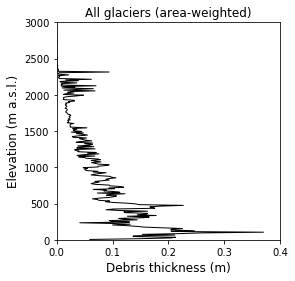

In [33]:
# Debris thickness vs. elevation (area-weighted)
hd_elev_weighted = (array_glac_hd * array_glac_hyps).sum(0) / array_glac_hyps.sum(0)

fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False)
elev_idx = np.where(hd_elev_weighted > 0)
ax[0,0].plot(hd_elev_weighted, np.array(outcols), 
             color='k', linewidth=1)
ax[0,0].set_ylabel('Elevation (m a.s.l.)', size=12)
ax[0,0].set_ylim(0,3000)
ax[0,0].set_xlabel('Debris thickness (m)', size=12)
ax[0,0].set_xlim(0,0.4)
ax[0,0].set_title('All glaciers (area-weighted)')
fig.set_size_inches(4, 4)

In [34]:
# Investigate relationships only on glaciers with significant debris cover
dc_shp = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
dc_shp = dc_shp.sort_values(by=['RGIId'])
dc_shp.reset_index(inplace=True, drop=True)

dc_areaperc_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area__1'].values))
main_glac_rgi_all['DC_Area_%'] = main_glac_rgi_all.RGIId.map(dc_areaperc_dict).fillna(0)
main_glac_rgi_all['DC_Area'] = main_glac_rgi_all['Area'] * main_glac_rgi_all['DC_Area_%'] / 100
main_glac_rgi_wdebris = main_glac_rgi_all.loc[main_glac_rgi_all['DC_Area_%'] > 0, :]

# Select subset of debris (only large glaciers with significant debris cover)
area_threshold = 2
dc_area_threshold = 1
main_glac_rgi_wdebris_subset = main_glac_rgi_wdebris[(main_glac_rgi_wdebris['Area'] > area_threshold) & 
                                                     (main_glac_rgi_wdebris['DC_Area'] > dc_area_threshold)]
debris_idxs_raw = main_glac_rgi_wdebris_subset.index.values
# main_glac_rgi_wdebris_subset.reset_index(inplace=True, drop=True)

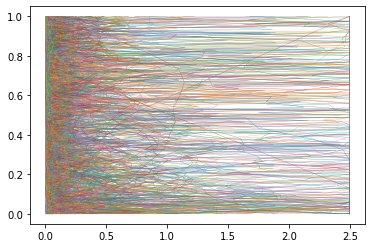

In [35]:
# Debris thickness vs. normalized elevation
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False)
debris_idxs = []
for glac_idx in debris_idxs_raw:
    hd_glac_raw = array_glac_hd[glac_idx,:]
    if np.max(hd_glac_raw) > 0:
        debris_idxs.append(glac_idx)
        hd_glac = hd_glac_raw[np.where(hd_glac_raw > 0)[0]]
        hd_norm = hd_glac / hd_glac.max()
        elev = np.array(outcols)[np.where(hd_glac_raw > 0)[0]]
        elev_norm = (elev - elev[0]) / (elev[-1] - elev[0])
        ax[0,0].plot(hd_glac, elev_norm, linewidth=0.25)
    
# ax[0,0].set_ylabel('Elevation (m a.s.l.)', size=12)
# ax[0,0].set_ylim(0,3000)
# ax[0,0].set_xlabel('Debris thickness (m)', size=12)
# ax[0,0].set_xlim(0,0.4)
# ax[0,0].set_title('All glaciers (area-weighted)')
# fig.set_size_inches(4, 4)

[5,
 8,
 14,
 23,
 26,
 31,
 36,
 37,
 39,
 40,
 55,
 59,
 60,
 74,
 79,
 88,
 102,
 118,
 121,
 128,
 134,
 136,
 165,
 166,
 171,
 181,
 186,
 195,
 201,
 237,
 251,
 273,
 284,
 286,
 287,
 288,
 290,
 307,
 309,
 310,
 316,
 319,
 325,
 334,
 338,
 340,
 347,
 350,
 352,
 353,
 355,
 358,
 359,
 360,
 369,
 381,
 423,
 434,
 435,
 446,
 451,
 457,
 466,
 471,
 483,
 487,
 489,
 493,
 517,
 519,
 523,
 528,
 534,
 542,
 546,
 551,
 557,
 560,
 564,
 571,
 573,
 595,
 596,
 599,
 600,
 655,
 659,
 666,
 668,
 685,
 686,
 689,
 701,
 705,
 708,
 715,
 725,
 726,
 727,
 739,
 749,
 764,
 770,
 772,
 775,
 777,
 779,
 782,
 783,
 787,
 790,
 794,
 801,
 804,
 822,
 823,
 825,
 835,
 847,
 861,
 867,
 868,
 869,
 870,
 885,
 894,
 900,
 906,
 920,
 926,
 929,
 930,
 931,
 942,
 945,
 954,
 958,
 976,
 986,
 987,
 994,
 995,
 1008,
 1012,
 1027,
 1029,
 1034,
 1042,
 1048,
 1049,
 1057,
 1076,
 1077,
 1080,
 1095,
 1096,
 1100,
 1106,
 1107,
 1108,
 1118,
 1119,
 1131,
 1133,
 1138,
 1150

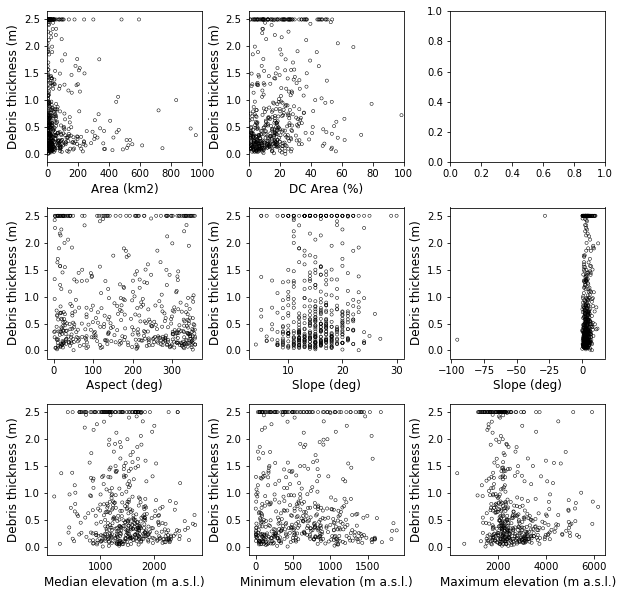

In [56]:
# Glacier morphological variables (from Brun et al. 2019):
#  - area
#  - aspect
#  - mean slope
#  - slope of the lowest 20% [tongue slope]
#  - median elevation
#  - minimum elevation
#  - maximum elevation
#  - area percentage of supraglacial debris cover [DC]
#  - avalanche contributing area [contrib. area])

# Maximum debris thickness vs. glacier properties
main_glac_rgi_wdebris_subset = main_glac_rgi_all.loc[debris_idxs,:]

hd_max_list = []
slope_tongue_list = []
for glac_idx in debris_idxs:
# for glac_idx in [14634]:
    # Maximum debris thickness
    hd_glac_raw = array_glac_hd[glac_idx,:]
    hd_glac = hd_glac_raw[np.where(hd_glac_raw > 0)[0]]
    hd_max = hd_glac.max()
    hd_max_list.append(hd_max)
    
    # Tongue slope (lowest 20%)
    hyps_glac_raw = array_glac_hyps[glac_idx,:]
    slope_glac_raw = array_glac_slope[glac_idx,:]
    
    hyps_glac_raw_cumsum_perc = np.cumsum(hyps_glac_raw) / hyps_glac_raw.sum() * 100
    tongue_idx = np.where((hyps_glac_raw_cumsum_perc < 20) & (hyps_glac_raw_cumsum_perc > 0))[0]
    if len(tongue_idx) == 0:
        tongue_idx = np.where(hyps_glac_raw_cumsum_perc > 0)[0][0]
        slope_tongue_weightedmean = slope_glac_raw[tongue_idx]
    else:
        slope_tongue_weightedmean = ((slope_glac_raw[tongue_idx] * hyps_glac_raw[tongue_idx]).sum() / 
                                      hyps_glac_raw[tongue_idx].sum())
    slope_tongue_list.append(slope_tongue_weightedmean)

    
# ===== PLOT MAX DEBRIS THICKNESS VERSUS GLACIER MORPHOLOGICAL VARIABLES =====
fig, ax = plt.subplots(3, 3, squeeze=False, sharex=False, sharey=False, 
                       gridspec_kw = {'wspace':0.3, 'hspace':0.3}
                      )
linewidth = 0.5
linecolor='k'
marker='o'
facecolor='none'
markersize=10

# Glacier morphological variables (from Brun et al. 2019):
#  - area
#  - area percentage of supraglacial debris cover [DC]
#  - area avalanche contributing [contrib. area])
#  - aspect
#  - mean slope
#  - slope of the lowest 20% [tongue slope]
#  - median elevation
#  - minimum elevation
#  - maximum elevation


# ===== 1. Max debris thickness vs. Area ===== 
ax[0,0].scatter(main_glac_rgi_wdebris_subset['Area'].values, hd_max_list,
                color=linecolor, marker=marker, facecolor=facecolor, linewidth=linewidth, s=markersize)
ax[0,0].set_ylabel('Debris thickness (m)', size=12)
ax[0,0].set_xlabel('Area (km2)', size=12)
ax[0,0].set_xlim(0,1000)

# ===== 2. Max debris thickness vs. DC Area % ===== 
ax[0,1].scatter(main_glac_rgi_wdebris_subset['DC_Area_%'].values, hd_max_list,
                color=linecolor, marker=marker, facecolor=facecolor, linewidth=linewidth, s=markersize)
ax[0,1].set_ylabel('Debris thickness (m)', size=12)
ax[0,1].set_xlabel('DC Area (%)', size=12)
ax[0,1].set_xlim(0,100)

# ===== 4. Max debris thickness vs. Aspect ===== 
ax[1,0].scatter(main_glac_rgi_wdebris_subset['Aspect'].values, hd_max_list,
                color=linecolor, marker=marker, facecolor=facecolor, linewidth=linewidth, s=markersize)
ax[1,0].set_ylabel('Debris thickness (m)', size=12)
ax[1,0].set_xlabel('Aspect (deg)', size=12)

# ===== 5. Max debris thickness vs. Slope ===== 
ax[1,1].scatter(main_glac_rgi_wdebris_subset['Slope'].values, hd_max_list,
                color=linecolor, marker=marker, facecolor=facecolor, linewidth=linewidth, s=markersize)
ax[1,1].set_ylabel('Debris thickness (m)', size=12)
ax[1,1].set_xlabel('Slope (deg)', size=12)

# ===== 6. Max debris thickness vs. Slope ===== 
ax[1,2].scatter(slope_tongue_list, hd_max_list,
                color=linecolor, marker=marker, facecolor=facecolor, linewidth=linewidth, s=markersize)
ax[1,2].set_ylabel('Debris thickness (m)', size=12)
ax[1,2].set_xlabel('Slope (deg)', size=12)

# ===== 7. Max debris thickness vs. Median elevation ===== 
ax[2,0].scatter(main_glac_rgi_wdebris_subset['Zmed'].values, hd_max_list,
                color=linecolor, marker=marker, facecolor=facecolor, linewidth=linewidth, s=markersize)
ax[2,0].set_ylabel('Debris thickness (m)', size=12)
ax[2,0].set_xlabel('Median elevation (m a.s.l.)', size=12)

# ===== 8. Max debris thickness vs. Min elevation ===== 
ax[2,1].scatter(main_glac_rgi_wdebris_subset['Zmin'].values, hd_max_list,
                color=linecolor, marker=marker, facecolor=facecolor, linewidth=linewidth, s=markersize)
ax[2,1].set_ylabel('Debris thickness (m)', size=12)
ax[2,1].set_xlabel('Minimum elevation (m a.s.l.)', size=12)

# ===== 9. Max debris thickness vs. Max elevation ===== 
ax[2,2].scatter(main_glac_rgi_wdebris_subset['Zmax'].values, hd_max_list,
                color=linecolor, marker=marker, facecolor=facecolor, linewidth=linewidth, s=markersize)
ax[2,2].set_ylabel('Debris thickness (m)', size=12)
ax[2,2].set_xlabel('Maximum elevation (m a.s.l.)', size=12)


    
fig.set_size_inches(10, 10)

In [15]:
print('\n\nOld processing - can delete after next push (01/31/2020) \n\n')
# bin_glaciers = False

# if bin_glaciers:
#     # ===== PROCESS EACH GLACIER =====
#     for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
#     # for nglac, glac_idx in enumerate([main_glac_rgi.index.values[238]]):

#         glac_str = main_glac_rgi.loc[glac_idx,'rgino_str']
#         rgiid = main_glac_rgi.loc[glac_idx,'RGIId']
#         region = glac_str.split('.')[0]

#         if int(region) < 10:
#             glac_str_noleadzero = str(int(glac_str.split('.')[0])) + '.' + glac_str.split('.')[1]
#         else:
#             glac_str_noleadzero = glac_str

#         print(nglac, glac_idx, rgiid)

#         if glac_str_noleadzero in rgiid_list_opt:
#             hd_fp = input.hd_fp
#             hd_ending = '_hdts_m.tif'
#             mf_fp = input.mf_fp
#             mf_ending = '_meltfactor.tif'

#         elif glac_str_noleadzero in rgiid_list_extrap:
#             hd_fp = input.hd_fp + '_extrap/'
#             hd_ending = '_hdts_m_extrap.tif'
#             mf_fp = hd_fp + '_meltfactor/'
#             mf_ending = '_meltfactor_extrap.tif'
#     #         print('\n\nADD FILE PATH FOR EXTRAPOLATED GLACIERS\n\n')

#         # ===== Project shapefile =====
#         huss_dir = input.huss_dir_sample.replace('XXXX',str(region.zfill(2)))
#         huss_fn = input.huss_fn_sample.replace('XXXX',glac_str)

#         proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
#         ds = gdal.Open(proj_fn)
#         prj = ds.GetProjection()
#         srs = osr.SpatialReference(wkt=prj)
#         aea_srs = srs

#         # Shape layer processing
#         # If projected shapefile already exists, then skip projection
#         glac_shp_proj_fn = (input.glac_shp_proj_fp + glac_str + '_crs' + 
#                             str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
#         dc_shp_proj_fn = (input.glac_shp_proj_fp + glac_str + '_dc_crs' + 
#                           str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
#         if os.path.exists(glac_shp_proj_fn) == False:
#             glac_shp_init = gpd.read_file(input.glac_shp_fn_dict[region])
#             if verbose:
#                 print('Shp init crs:', glac_shp_init.crs)
#             glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
#             glac_shp_single = glac_shp_single.reset_index()
#             glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
#             glac_shp_proj.to_file(glac_shp_proj_fn)

#         if os.path.exists(dc_shp_proj_fn) == False:
#             dc_shp_init = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
#             dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
#             dc_shp_single = dc_shp_single.reset_index()
#             dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
#             dc_shp_proj.to_file(dc_shp_proj_fn)

#         glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
#         glac_shp_lyr = glac_shp_ds.GetLayer()
#         #This should be contained in features
#         glac_shp_srs = glac_shp_lyr.GetSpatialRef()
#         feat_count = glac_shp_lyr.GetFeatureCount()
#         if verbose:
#             print("Input glacier polygon count: %i" % feat_count)

#         dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
#         dc_shp_lyr = dc_shp_ds.GetLayer()
#         #This should be contained in features
#         dc_shp_srs = dc_shp_lyr.GetSpatialRef()
#         feat_count = dc_shp_lyr.GetFeatureCount()
#         if verbose:
#             print("Input glacier polygon count (debris cover): %i" % feat_count)

#         # Load DEM
#         z1_dir = input.z1_dir_sample.replace('XXXX',str(region.zfill(2)))
#         z1_fn = input.z1_fn_sample.replace('XXXX',glac_str)
#         z1_ds = gdal.Open(z1_dir + z1_fn)
#         z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

#         glacname_fieldname = "Name"
#         glacnum_fieldname = "RGIId"
#         glacnum_fmt = '%08.5f'

#         for n, feat in enumerate(glac_shp_lyr):
#             gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
#             if verbose:
#                 print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
#             #NOTE: Input must be in projected coordinate system, ideally equal area
#             #Should check this and reproject
#             gf.geom_attributes(srs=aea_srs)

#         if verbose:
#             print(gf.feat_fn)


#         fn_dict = OrderedDict()
#         #We at least want to warp the two input DEMs
#         fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

#         if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
#             if verbose:
#                 print(gf.glacnum)

#             # Ice thickness data
#             ice_thick_fn = os.path.join(huss_dir, huss_fn)
#             if os.path.exists(ice_thick_fn):
#                 fn_dict['ice_thick'] = ice_thick_fn

#             if os.path.exists(input.v_dir + input.vx_fn_dict[input.roi]):
#                 fn_dict['vx'] = input.v_dir + input.vx_fn_dict[input.roi]
#                 fn_dict['vy'] = input.v_dir + input.vy_fn_dict[input.roi]

#             if os.path.exists(input.ts_fp + input.ts_fn_dict[input.roi]):
#                 fn_dict['ts'] = input.ts_fp + input.ts_fn_dict[input.roi]

#             # Debris thickness
#             if os.path.exists(hd_fp + glac_str_noleadzero + hd_ending):
#                 fn_dict['debris_thick_ts'] = hd_fp + glac_str_noleadzero + hd_ending

#             # Melt factor
#             if os.path.exists(mf_fp + glac_str_noleadzero + mf_ending):
#                 fn_dict['meltfactor_ts'] = mf_fp + glac_str_noleadzero + mf_ending

#         #Expand extent to include buffered region around glacier polygon
#         warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=input.buff_dist)
#         if verbose:
#             print("Expanding extent")
#             print(gf.glac_geom_extent)
#             print(warp_extent)
#             print(aea_srs)

#         #Warp everything to common res/extent/proj
#         z1_gt = gdal.Open(fn_dict['z1']).GetGeoTransform()
#         z1_res = np.min([z1_gt[1], -z1_gt[5]])
#         ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
#                 extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
#                 r='cubic')
#         ds_dict = dict(zip(fn_dict.keys(), ds_list))

#         if verbose:
#             print(ds_list)
#             print(fn_dict.keys())

#         #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
#         glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
#         glac_shp_lyr = glac_shp_ds.GetLayer()
#         dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
#         dc_shp_lyr = dc_shp_ds.GetLayer()

#         #Get global glacier mask
#         #Want this to be True over ALL glacier surfaces, not just the current polygon
#         glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
#         dc_shp_lyr_mask = geolib.lyr2mask(dc_shp_lyr, ds_dict['ice_thick'])

#         #Create buffer around glacier polygon
#         glac_geom_buff = gf.glac_geom.Buffer(input.buff_dist)
#         #This is False over glacier polygon surface, True elsewhere - can be applied directly
#         glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

#         # ds masks
#         ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
#         dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
#         dems_mask = dem1.mask
#         if verbose:
#             print('list of datasets:', len(ds_list_masked), fn_dict.values())

#         #Combine to identify ~1 km buffer around glacier polygon over static rock
#         static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
#         static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

#         if 'z1' in ds_dict:
#             #This is False over glacier polygon surface, True elsewhere - can be applied directly
#             glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
#             gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
#             #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

#             # Debris cover
#             dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
#             gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=dc_mask)

#             # Check if DEM has huge errors or not - replace if necessary
#             if input.roi in ['01']:

#                 gf.z1_check = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
#                 if gf.z1_check.min() < 0:

#                     # Add backup DEM for regions with known poor quality (ex. Alaska)
#                     print('switching DEMs')
#                     fn_dict['z1_backup'] = input.z1_backup_dict[input.roi]
#                     # Warp everything to common res/extent/proj (a second time)
#                     ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
#                             extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
#                             r='cubic')
#                     ds_dict = dict(zip(fn_dict.keys(), ds_list))

#                     if verbose:
#                         print(ds_list)
#                         print(fn_dict.keys())

#                     # ds masks
#                     ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
#                     dem1 = np.ma.masked_less_equal(ds_list_masked[-1], 0)
#                     dems_mask = dem1.mask
#                     if verbose:
#                         print('list of datasets:', len(ds_list_masked), fn_dict.values())

#                     #Combine to identify ~1 km buffer around glacier polygon over static rock
#                     static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
#                     static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

#                     #This is False over glacier polygon surface, True elsewhere - can be applied directly
#                     glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1_backup'])
#                     gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=glac_geom_mask)
#                     #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

#                     # Debris cover
#                     dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
#                     gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=dc_mask)


#             if verbose:
#                 print('\n\n# z1 pixels:', gf.z1.count(), '\n')
#             if gf.z1.count() == 0:
#                 if verbose:
#                     print("No z1 pixels")
#         else:
#             print("Unable to load z1 ds")

#         # ===== ADD VARIOUS LAYERS TO gf =====
#         if nglac == 0:
#             print('\n\nHACK TO BYPASS VALID AREA\n\n')
#         gf.valid_area_perc = 100

#         if gf.valid_area_perc < (100. * input.min_valid_area_perc):
#             if verbose:
#                 print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
#         #     return None

#         else:
#             #Filter dz - throw out abs differences >150 m

#             #Compute dz, volume change, mass balance and stats
#             gf.z1_stats = malib.get_stats(gf.z1)
#             z1_elev_med = gf.z1_stats[5]
#             z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

#             #Caluclate stats for aspect and slope using z2
#             #Requires GDAL 2.1+
#             gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
#             gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
#             z1_aspect_med = gf.z1_aspect_stats[5]
#             gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
#             gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
#             z1_slope_med = gf.z1_slope_stats[5]

#             #Can estimate ELA values computed from hypsometry and typical AAR
#             #For now, assume ELA is mean
#             gf.z1_ela = None
#             gf.z1_ela = gf.z1_stats[3]
#             #Note: in theory, the ELA should get higher with mass loss
#             #In practice, using mean and same polygon, ELA gets lower as glacier surface thins

#             # copy for Ts because it change the mask otherwise and messes up binned statistics for whole glacier
#             glac_geom_mask_copy = glac_geom_mask.copy()

#             if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
#                 if 'ice_thick' in ds_dict:
#                     #Load ice thickness
#                     gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
#                     gf.H_mean = gf.H.mean()
#                     if verbose:
#                         print('mean ice thickness [m]:', gf.H_mean)

#                 if 'vx' in ds_dict and 'vy' in ds_dict:
#                     #Load surface velocity maps
#                     gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
#                     gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
#     #                             gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask_copy)
#     #                             gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask_copy)
#                     gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
#                     gf.vm_mean = gf.vm.mean()
#                     if verbose:
#                         print('mean velocity [m/s]:', gf.vm_mean)

#                     if gf.H is not None:
#                         #Compute flux
#                         gf.Q = gf.H * input.v_col_f * np.array([gf.vx, gf.vy])
#                         #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
#                         #Want x-derivative of x component
#                         gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

#         #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
#         #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

#                         #Should smooth divQ, better handling of data gaps

#                 if 'ts' in ds_dict:
#                     #Load surface temperature maps
#                     gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask_copy)
#                     gf.ts.mask = np.ma.mask_or(glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
#                 else:
#                     gf.ts = None

#                 if 'debris_thick_ts' in ds_dict:
#                     # Load debris thickness map
#                     gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask_copy)
#                 else:
#                     gf.debris_thick_ts = None

#                 if 'meltfactor_ts' in ds_dict:
#                     gf.meltfactor_ts = np.ma.array(iolib.ds_getma(ds_dict['meltfactor_ts']), mask=glac_geom_mask_copy)
#                 else:
#                     gf.meltfactor_ts = None

#             gf.res = geolib.get_res(ds_dict['z1'])

#             if verbose:
#                 print('Area [km2]:', gf.glac_area / 1e6)
#                 print('-------------------------------')


#             gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

#             # Columns and rows to estimate median pixel of each bin for slope calculations
#             col_num_array = np.zeros(gf.z1.shape)
#             row_num_array = np.zeros(gf.z1.shape)
#             for n in np.arange(gf.z1.shape[0]):
#                 col_num_array[n,:] = n
#             for n in np.arange(gf.z1.shape[1]):
#                 row_num_array[:,n] = n
#             gf.col_array = np.ma.array(col_num_array * gf.res[0], mask=np.ma.getmask(gf.z1))  
#             gf.row_array = np.ma.array(row_num_array * gf.res[1], mask=np.ma.getmask(gf.z1)) 

#     #         # ===== PLOT DEM =====
#     #         titles = [glac_str + ' DEM']
#     #         var_full2plot = gf.z1.copy()
#     #         clim = malib.calcperc(var_full2plot, (2,98))
#     #         plot_array(var_full2plot, clim, titles, 'inferno', 'elev (masl)', 
#     #                    close_fig=False)


#     #         titles = [gf.glacnum + ' hd (from ts)']
#     #         var_full2plot = gf.debris_thick_ts.copy()
#     #         var_full2plot.mask = dc_mask
#     #         clim = (0,1)
#     #         plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', 
#     #                    close_fig=False)

#     #         titles = [gf.glacnum + ' mf (from ts)']
#     #         var_full2plot = gf.meltfactor_ts.copy()
#     #         var_full2plot.mask = dc_mask
#     #         clim = (0,1.25)
#     #         plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', 
#     #                    close_fig=False)


#             # ===== BIN DATA =====
#             outbins_df, z_bin_edges = hist_plot(gf, bin_width=pygem_binwidth, exportcsv=False)

#             # Fill nan values for debris cover
#             outbins_df.loc[np.where(np.isnan(outbins_df['hd_ts_med_m']))[0], 'hd_ts_med_m'] = 0
#             outbins_df.loc[np.where(np.isnan(outbins_df['hd_ts_mean_m']))[0], 'hd_ts_mean_m'] = 0
#             outbins_df.loc[np.where(np.isnan(outbins_df['hd_ts_std_m']))[0], 'hd_ts_std_m'] = 0
#             outbins_df.loc[np.where(np.isnan(outbins_df['hd_ts_mad_m']))[0], 'hd_ts_mad_m'] = 0
#             outbins_df.loc[np.where(np.isnan(outbins_df['mf_ts_med']))[0], 'mf_ts_med'] = 1
#             outbins_df.loc[np.where(np.isnan(outbins_df['mf_ts_mean']))[0], 'mf_ts_mean'] = 1
#             outbins_df.loc[np.where(np.isnan(outbins_df['mf_ts_std']))[0], 'mf_ts_std'] = 0
#             outbins_df.loc[np.where(np.isnan(outbins_df['mf_ts_mad']))[0], 'mf_ts_mad'] = 0        
#             # Slope based on median row and column
#             outbins_df['slope_deg_raw'] = -9999
#             outbins_df.loc[1:,'slope_deg_raw'] = (
#                 (outbins_df.loc[1:,'col_m_med'] - outbins_df.loc[0:outbins_df.shape[0]-2,'col_m_med']))
#             outbins_df.loc[1:,'slope_deg_raw'] = (
#                 np.arctan(pygem_binwidth / 
#                           ((outbins_df.loc[1:,'col_m_med'].values - outbins_df.loc[0:outbins_df.shape[0]-2,'col_m_med'].values)**2
#                           + (outbins_df.loc[1:,'row_m_med'].values - outbins_df.loc[0:outbins_df.shape[0]-2,'row_m_med'].values)**2)**0.5)
#                 * 180 / np.pi)
#             outbins_df.loc[0,'slope_deg_raw'] = outbins_df.loc[1,'slope_deg_raw']

#             if len(np.where(np.isnan(outbins_df['slope_deg_raw']))[0]) > 0:
#                 nan_idx = np.where(np.isnan(outbins_df['slope_deg_raw']))[0]
#                 real_idx = np.where(np.isnan(outbins_df['slope_deg_raw']) == False)[0]
#                 # Fill with mean slope
#                 outbins_df.loc[nan_idx, 'slope_deg_raw'] = outbins_df.loc[real_idx,'slope_deg_raw'].mean()

#                 # Nearest neighbor
#             #     print('this breaks down when in accumulation areas with tributaries')
#             #     for nidx in nan_idx:
#             #         nearidx = np.where(np.absolute(nidx - real_idx) == np.absolute(nidx - real_idx).min())[0][0]
#             #         outbins_df.loc[nidx,'slope_deg'] = outbins_df.loc[nearidx,'slope_deg']


#             # Length and width based on slope and are
#             outbins_df['length_raw'] = -9999
#             outbins_df['length_raw'] = pygem_binwidth / np.tan(outbins_df['slope_deg_raw'].values * np.pi / 180)
#             outbins_df['width_raw'] = outbins_df[' z1_bin_area_valid_km2'].values * 10**6 / outbins_df['length_raw'].values

#             # Average widths of bins above and below to smooth
#             outbins_df['width'] = outbins_df['width_raw']
#             outbins_df.loc[1:outbins_df.shape[0]-2, 'width'] = (
#                 outbins_df.loc[0:outbins_df.shape[0]-3, 'width_raw'].values +
#                 outbins_df.loc[1:outbins_df.shape[0]-2, 'width_raw'].values +
#                 outbins_df.loc[2:outbins_df.shape[0]-1, 'width_raw'].values) / 3
#             outbins_df.loc[0,'width'] = (outbins_df.loc[0, 'width_raw'] + outbins_df.loc[1, 'width_raw']) / 2
#             outbins_df.loc[outbins_df.shape[0]-1,'width'] = (
#                 outbins_df.loc[outbins_df.shape[0]-1, 'width_raw'] + outbins_df.loc[outbins_df.shape[0]-2, 'width_raw']) / 2
#             outbins_df['length'] = outbins_df[' z1_bin_area_valid_km2'].values * 10**6 / outbins_df['width'].values

#             # RECALCULATE LENGTH WITH SMOOTHED WIDTH
#             outbins_df['slope_deg'] = np.tan(pygem_binwidth / outbins_df['length'].values) * 180 / np.pi

#             # EXPORT BINS
#             outbins_df.to_csv(outdir_csv + glac_str + '_' + str(pygem_binwidth) + 'm.csv', index=False)

#             outbins_df.loc[0:10,['slope_deg_raw', 'slope_deg', 'length_raw', 'length', 'width_raw', 'width']]



Old processing - can delete after next push (01/31/2020) 


